In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef
import optuna
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-application-data/df1_loan.csv
/kaggle/input/test-appro/Test (4).csv
/kaggle/input/loan-appl/Train (6).csv


In [2]:
train_path='/kaggle/input/loan-appl/Train (6).csv'
train_additional_path='/kaggle/input/loan-application-data/df1_loan.csv'
test_path='/kaggle/input/test-appro/Test (4).csv'

In [3]:
train_csv=pd.read_csv(train_path)
additional_csv=pd.read_csv(train_additional_path)
test_csv=pd.read_csv(test_path)

In [4]:
print(train_csv.shape)
train_csv.head(10)

(5898, 15)


,ID,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,74768,LP002231,1,1,0,1,0,8328,0.000000,17,363,1,2,1,6000
1,79428,LP001448,1,1,0,0,0,150,3857.458782,188,370,1,1,0,6000
2,70497,LP002231,0,0,0,0,0,4989,314.472511,17,348,1,0,0,6000
3,87480,LP001385,1,1,0,0,0,150,0.000000,232,359,1,1,1,3750
4,33964,LP002231,1,1,1,0,0,8059,0.000000,17,372,1,0,1,3750
5,20364,LP001778,0,1,0,0,0,1911,4145.477647,65,373,1,2,1,6000
6,63354,LP002180,1,1,3+,0,0,7121,926.791025,17,425,1,1,1,6000
7,67110,LP002585,1,1,1,0,0,3417,647.162564,17,366,1,0,1,6000
8,69254,LP001385,1,1,1,1,0,15965,0.000000,17,347,1,2,1,6000
9,92855,LP002175,1,1,0,0,0,150,0.000000,268,373,1,2,1,3750


In [5]:
print(additional_csv.shape)
additional_csv.head(10)

(500, 15)


,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,$5849.0
1,1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,$6091.0
2,2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,$3000.0
3,3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,$4941.0
4,4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,$6000.0
5,5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,$9613.0
6,6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y,$3849.0
7,7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N,$5540.0
8,8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y,$5532.0
9,9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N,$23809.0


In [6]:
length=np.unique(train_csv['Loan_ID'])
print(len(length))

457


In [7]:
length=np.unique(additional_csv['Loan_ID'])
print(len(length))

500


In [8]:
train_csv[train_csv['Loan_ID']=='LP001014']

,ID,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
3259,81470,LP001014,1,1,0,0,0,3520,3832.635453,130,373,1,1,1,6000
3927,46333,LP001014,1,1,0,0,0,150,610.996606,17,354,1,2,0,3750
4939,86034,LP001014,1,1,0,0,0,5892,0.000000,119,364,1,0,0,3547


In [9]:
for i, string in enumerate(additional_csv['Total_Income']):
    additional_csv.loc[i,'Total_Income']=string.replace('$','')
additional_csv['Total_Income']

0       5849.0
1       6091.0
2       3000.0
3       4941.0
4       6000.0
        ...   
495     4239.0
496     4300.0
497     7482.0
498     2895.0
499    10699.0
Name: Total_Income, Length: 500, dtype: object

In [10]:
additional_csv.drop(columns=['Loan_ID','Unnamed: 0'],inplace=True)

In [11]:
additional_csv.isna().sum()

Gender                9
Married               3
Dependents           12
Education             0
Self_Employed        27
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           18
Loan_Amount_Term     14
Credit_History       41
Property_Area         0
Loan_Status           0
Total_Income          0
dtype: int64

In [12]:
from sklearn.impute import KNNImputer, SimpleImputer

In [13]:
cat_var=['Gender','Married','Dependents','Self_Employed','Credit_History']

In [14]:
simple_imputer = SimpleImputer(strategy='most_frequent')
additional_csv[cat_var]=simple_imputer.fit_transform(additional_csv[cat_var])

In [15]:
knn_imputer = KNNImputer(n_neighbors=5)
additional_csv[['LoanAmount','Loan_Amount_Term']]=knn_imputer.fit_transform(additional_csv[['LoanAmount','Loan_Amount_Term']])

In [16]:
additional_csv.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
Total_Income         0
dtype: int64

In [17]:
additional_csv['Gender']=np.where(additional_csv['Gender']=='Male',1,0)
additional_csv['Married']=np.where(additional_csv['Married']=='Yes',1,0)
additional_csv['Education']=np.where(additional_csv['Education']=='Graduate',1,0)
additional_csv['Self_Employed']=np.where(additional_csv['Self_Employed']=='Yes',1,0)
additional_csv['Loan_Status']=np.where(additional_csv['Loan_Status']=='Y',1,0)

In [18]:
additional_csv

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,1,0,0,1,0,5849,0.0,161.2,360.0,1.0,Urban,1,5849.0
1,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0
2,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0
3,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0
4,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,1,1,1,0,3326,913.0,105.0,84.0,1.0,Semiurban,1,4239.0
496,1,1,0,0,0,2600,1700.0,107.0,360.0,1.0,Rural,1,4300.0
497,1,1,0,1,0,4625,2857.0,111.0,12.0,1.0,Urban,1,7482.0
498,1,1,1,1,1,2895,0.0,95.0,360.0,1.0,Semiurban,1,2895.0


In [19]:
additional_csv['Property_Area'].replace({'Rural':0,'Semiurban':1,'Urban':2},inplace=True)

In [20]:
train_csv

,ID,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,74768,LP002231,1,1,0,1,0,8328,0.000000,17,363,1,2,1,6000
1,79428,LP001448,1,1,0,0,0,150,3857.458782,188,370,1,1,0,6000
2,70497,LP002231,0,0,0,0,0,4989,314.472511,17,348,1,0,0,6000
3,87480,LP001385,1,1,0,0,0,150,0.000000,232,359,1,1,1,3750
4,33964,LP002231,1,1,1,0,0,8059,0.000000,17,372,1,0,1,3750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5893,65288,LP002560,0,1,0,0,0,1297,3293.124489,17,373,1,1,1,3750
5894,86963,LP002585,1,1,0,0,0,7358,0.000000,17,365,1,2,1,3547
5895,69407,LP002175,1,1,2,0,0,150,0.000000,170,353,1,1,1,3750
5896,82002,LP002560,1,0,0,0,0,2230,0.000000,222,367,1,2,0,3750


In [21]:
train_csv.drop(columns=['ID'],inplace=True)
train_csv

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP002231,1,1,0,1,0,8328,0.000000,17,363,1,2,1,6000
1,LP001448,1,1,0,0,0,150,3857.458782,188,370,1,1,0,6000
2,LP002231,0,0,0,0,0,4989,314.472511,17,348,1,0,0,6000
3,LP001385,1,1,0,0,0,150,0.000000,232,359,1,1,1,3750
4,LP002231,1,1,1,0,0,8059,0.000000,17,372,1,0,1,3750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5893,LP002560,0,1,0,0,0,1297,3293.124489,17,373,1,1,1,3750
5894,LP002585,1,1,0,0,0,7358,0.000000,17,365,1,2,1,3547
5895,LP002175,1,1,2,0,0,150,0.000000,170,353,1,1,1,3750
5896,LP002560,1,0,0,0,0,2230,0.000000,222,367,1,2,0,3750


In [22]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5898 entries, 0 to 5897
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            5898 non-null   object 
 1   Gender             5898 non-null   int64  
 2   Married            5898 non-null   int64  
 3   Dependents         5898 non-null   object 
 4   Education          5898 non-null   int64  
 5   Self_Employed      5898 non-null   int64  
 6   ApplicantIncome    5898 non-null   int64  
 7   CoapplicantIncome  5898 non-null   float64
 8   LoanAmount         5898 non-null   int64  
 9   Loan_Amount_Term   5898 non-null   int64  
 10  Credit_History     5898 non-null   int64  
 11  Property_Area      5898 non-null   int64  
 12  Loan_Status        5898 non-null   int64  
 13  Total_Income       5898 non-null   int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 645.2+ KB


In [23]:
train_csv.describe()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
count,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000
mean,0.910817,0.854527,0.120210,0.107664,7782.026958,1245.954548,97.410478,359.114954,0.920482,1.183961,0.832994,5239.284503
std,0.285032,0.352607,0.325235,0.309981,9182.571831,2368.012349,103.483478,48.876088,0.270569,0.730568,0.373013,2308.679455
min,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,17.000000,12.000000,0.000000,0.000000,0.000000,1963.000000
25%,1.000000,1.000000,0.000000,0.000000,2342.250000,0.000000,17.000000,357.000000,1.000000,1.000000,1.000000,3750.000000
50%,1.000000,1.000000,0.000000,0.000000,6989.000000,117.562275,42.000000,368.000000,1.000000,1.000000,1.000000,6000.000000
75%,1.000000,1.000000,0.000000,0.000000,8375.000000,1680.894542,174.000000,372.000000,1.000000,2.000000,1.000000,6000.000000
max,1.000000,1.000000,1.000000,1.000000,81000.000000,20000.000000,700.000000,480.000000,1.000000,2.000000,1.000000,22500.000000


In [24]:
train_csv.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'Total_Income'],
      dtype='object')

In [25]:
def seperate_features(df):
    cont_var=[]
    cat_var=[]
    for i in df.columns:
        if df[i].dtype=='object':
            cat_var.append(i)
        else:
            cont_var.append(i)
    return cat_var,cont_var        

In [26]:
cat_var,cont_var=seperate_features(train_csv)

In [27]:
cat_var

['Loan_ID', 'Dependents']

In [28]:
cont_var

['Gender',
 'Married',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'Loan_Status',
 'Total_Income']

In [29]:
train_csv=pd.concat([train_csv,additional_csv],axis=0)

In [30]:
train_csv

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP002231,1,1,0,1,0,8328,0.000000,17.0,363.0,1,2,1,6000
1,LP001448,1,1,0,0,0,150,3857.458782,188.0,370.0,1,1,0,6000
2,LP002231,0,0,0,0,0,4989,314.472511,17.0,348.0,1,0,0,6000
3,LP001385,1,1,0,0,0,150,0.000000,232.0,359.0,1,1,1,3750
4,LP002231,1,1,1,0,0,8059,0.000000,17.0,372.0,1,0,1,3750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,0,1,1,1,0,3326,913.000000,105.0,84.0,1.0,1,1,4239.0
496,NaN,1,1,0,0,0,2600,1700.000000,107.0,360.0,1.0,0,1,4300.0
497,NaN,1,1,0,1,0,4625,2857.000000,111.0,12.0,1.0,2,1,7482.0
498,NaN,1,1,1,1,1,2895,0.000000,95.0,360.0,1.0,1,1,2895.0


In [31]:
train_csv.isna().sum()

Loan_ID              500
Gender                 0
Married                0
Dependents             0
Education              0
Self_Employed          0
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount             0
Loan_Amount_Term       0
Credit_History         0
Property_Area          0
Loan_Status            0
Total_Income           0
dtype: int64

# **EDA**

In [32]:
def plot_cont(df,cont_var):
    for value in cont_var:
        fig,axes=plt.subplots(1,2,figsize=(20,19))
        sns.histplot(df[value],kde=True,ax=axes[0])
        axes[0].set_title(f'Histogram and KDE of {value}') 
        axes[0].set_xlabel(value)
        axes[0].set_ylabel('Frequency')
        sns.boxplot(x='Loan_Status',y=value,data=df,ax=axes[1])
        axes[1].set_title(f'Box Plot of {value} by Loan Status')  
        axes[1].set_xlabel('Loan Status') 
        axes[1].set_ylabel(value)
        
        plt.tight_layout()
        plt.show()
        
        

In [33]:
cont_var=['Total_Income','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']

In [34]:
train_csv['Total_Income']=train_csv['Total_Income'].astype('float32')

In [35]:
train_csv['Total_Income']

0       6000.0
1       6000.0
2       6000.0
3       3750.0
4       3750.0
        ...   
495     4239.0
496     4300.0
497     7482.0
498     2895.0
499    10699.0
Name: Total_Income, Length: 6398, dtype: float32

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


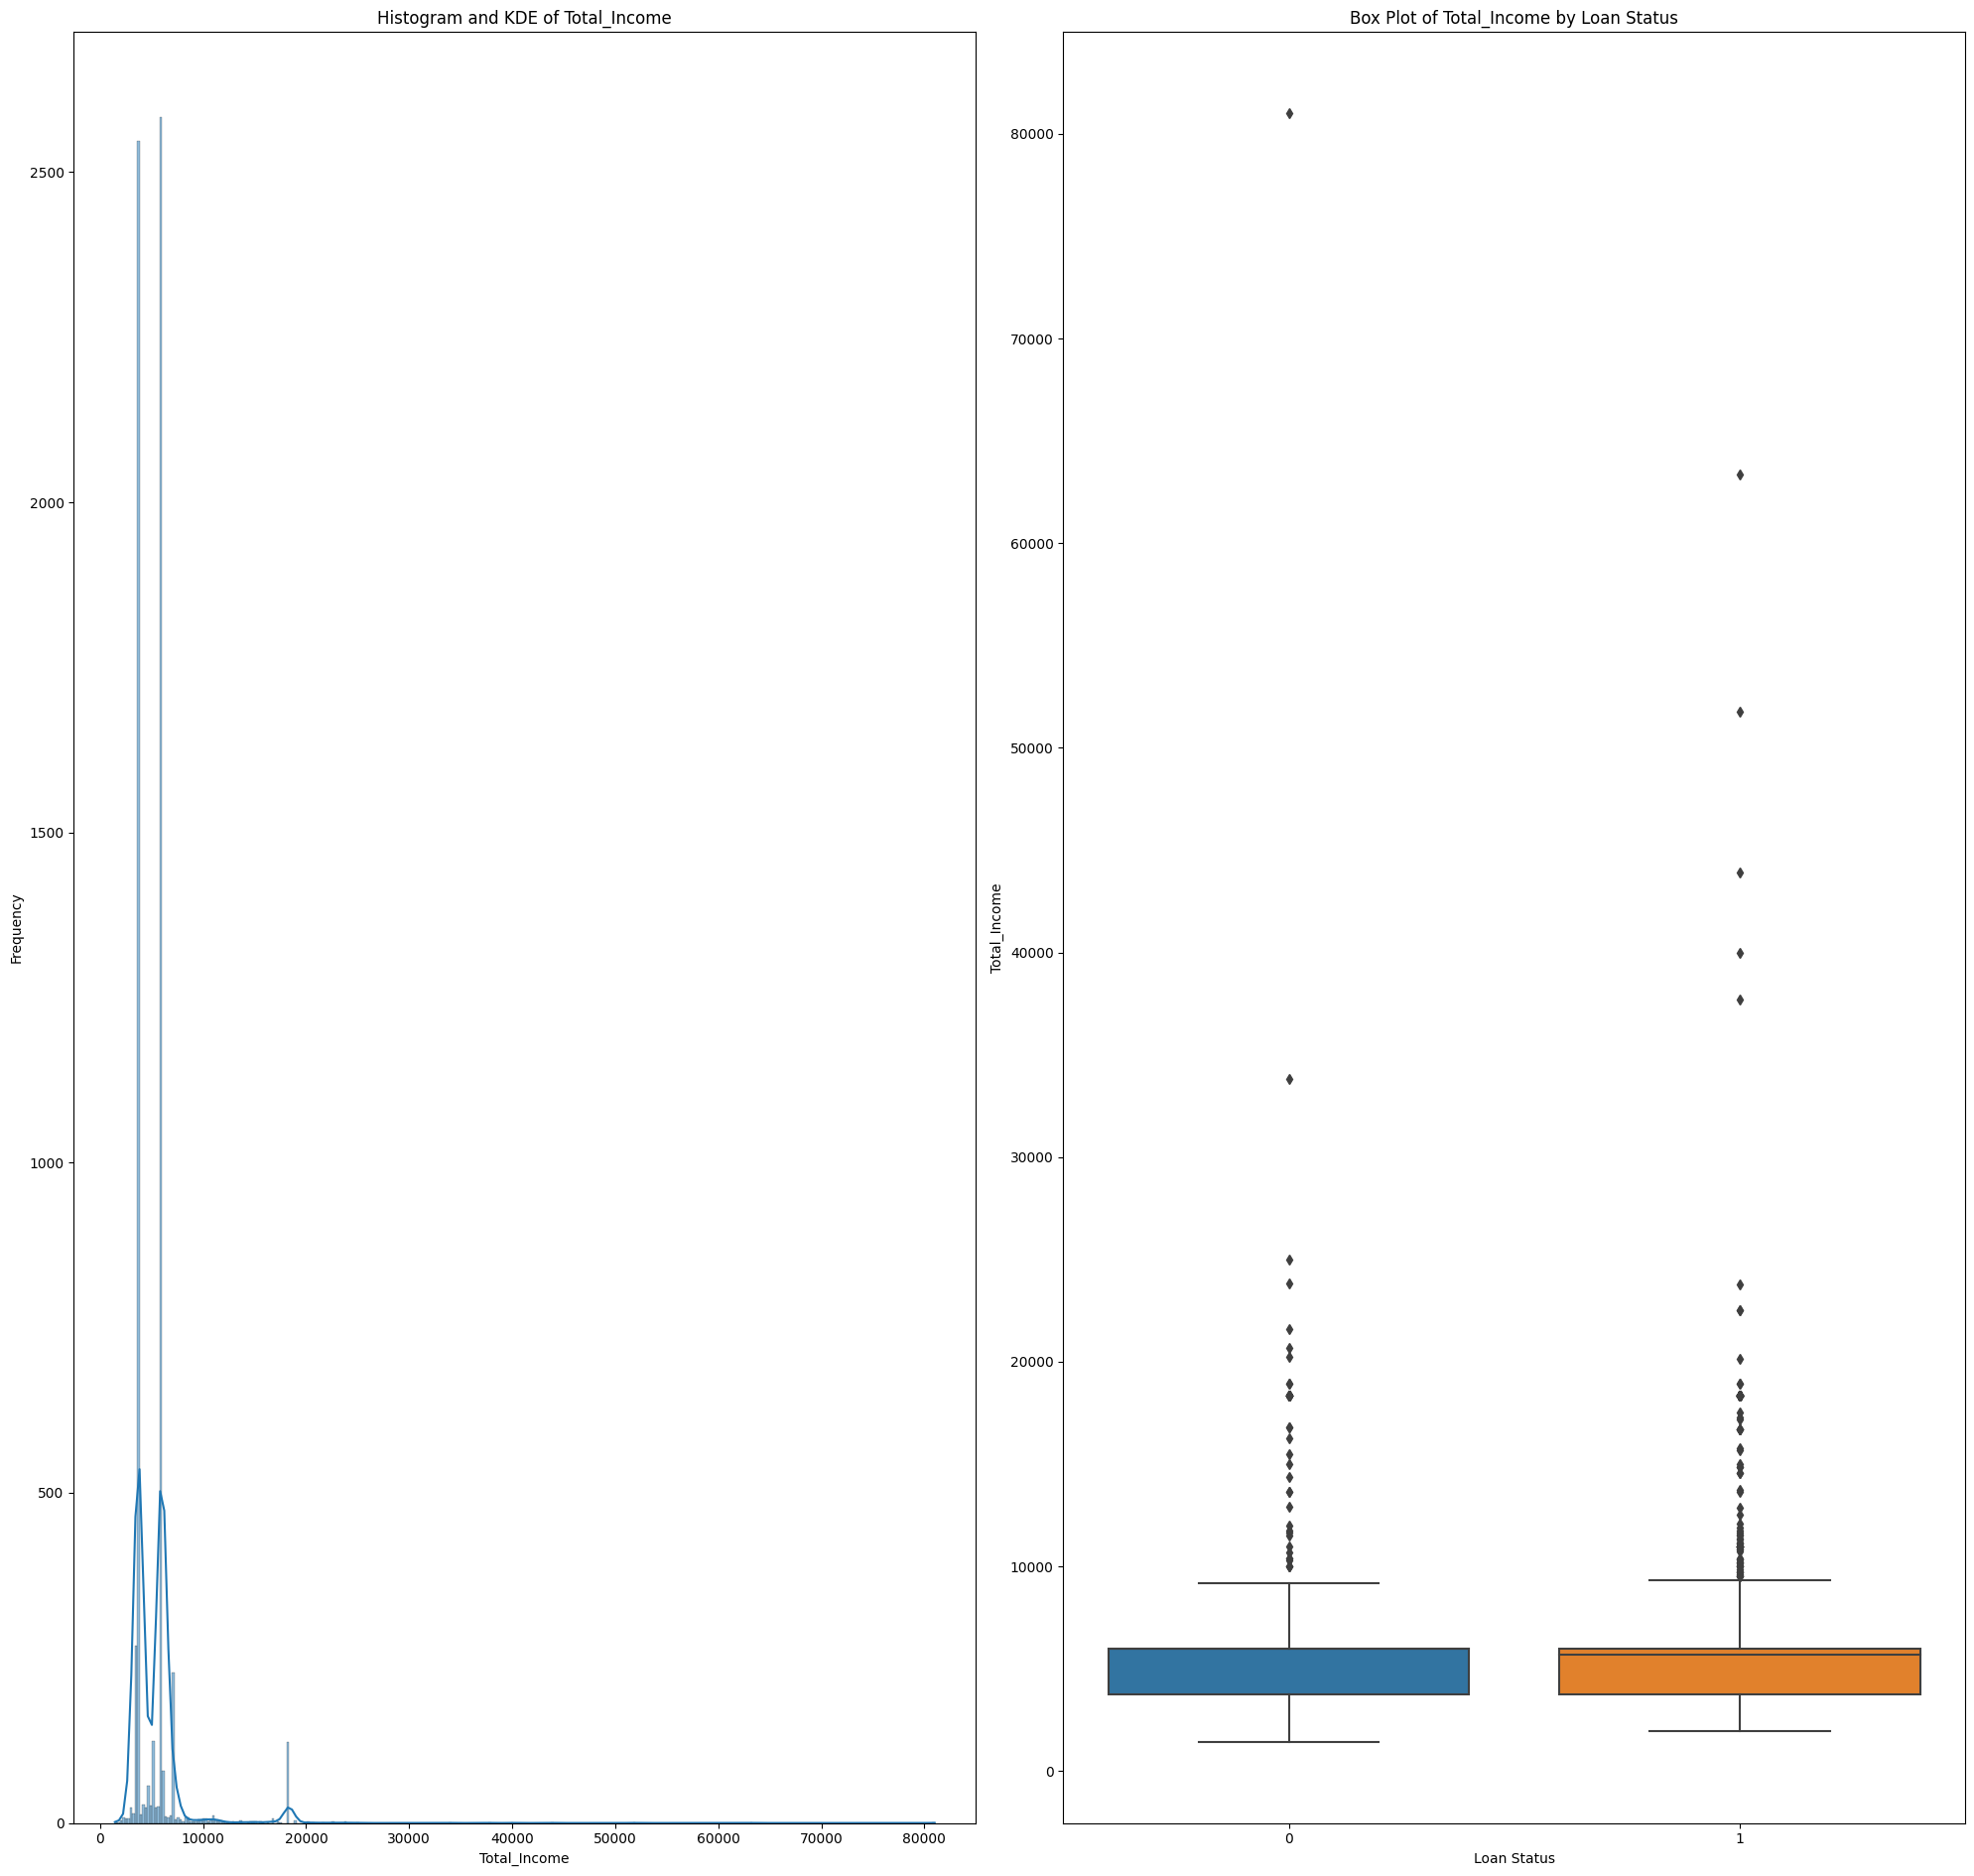

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


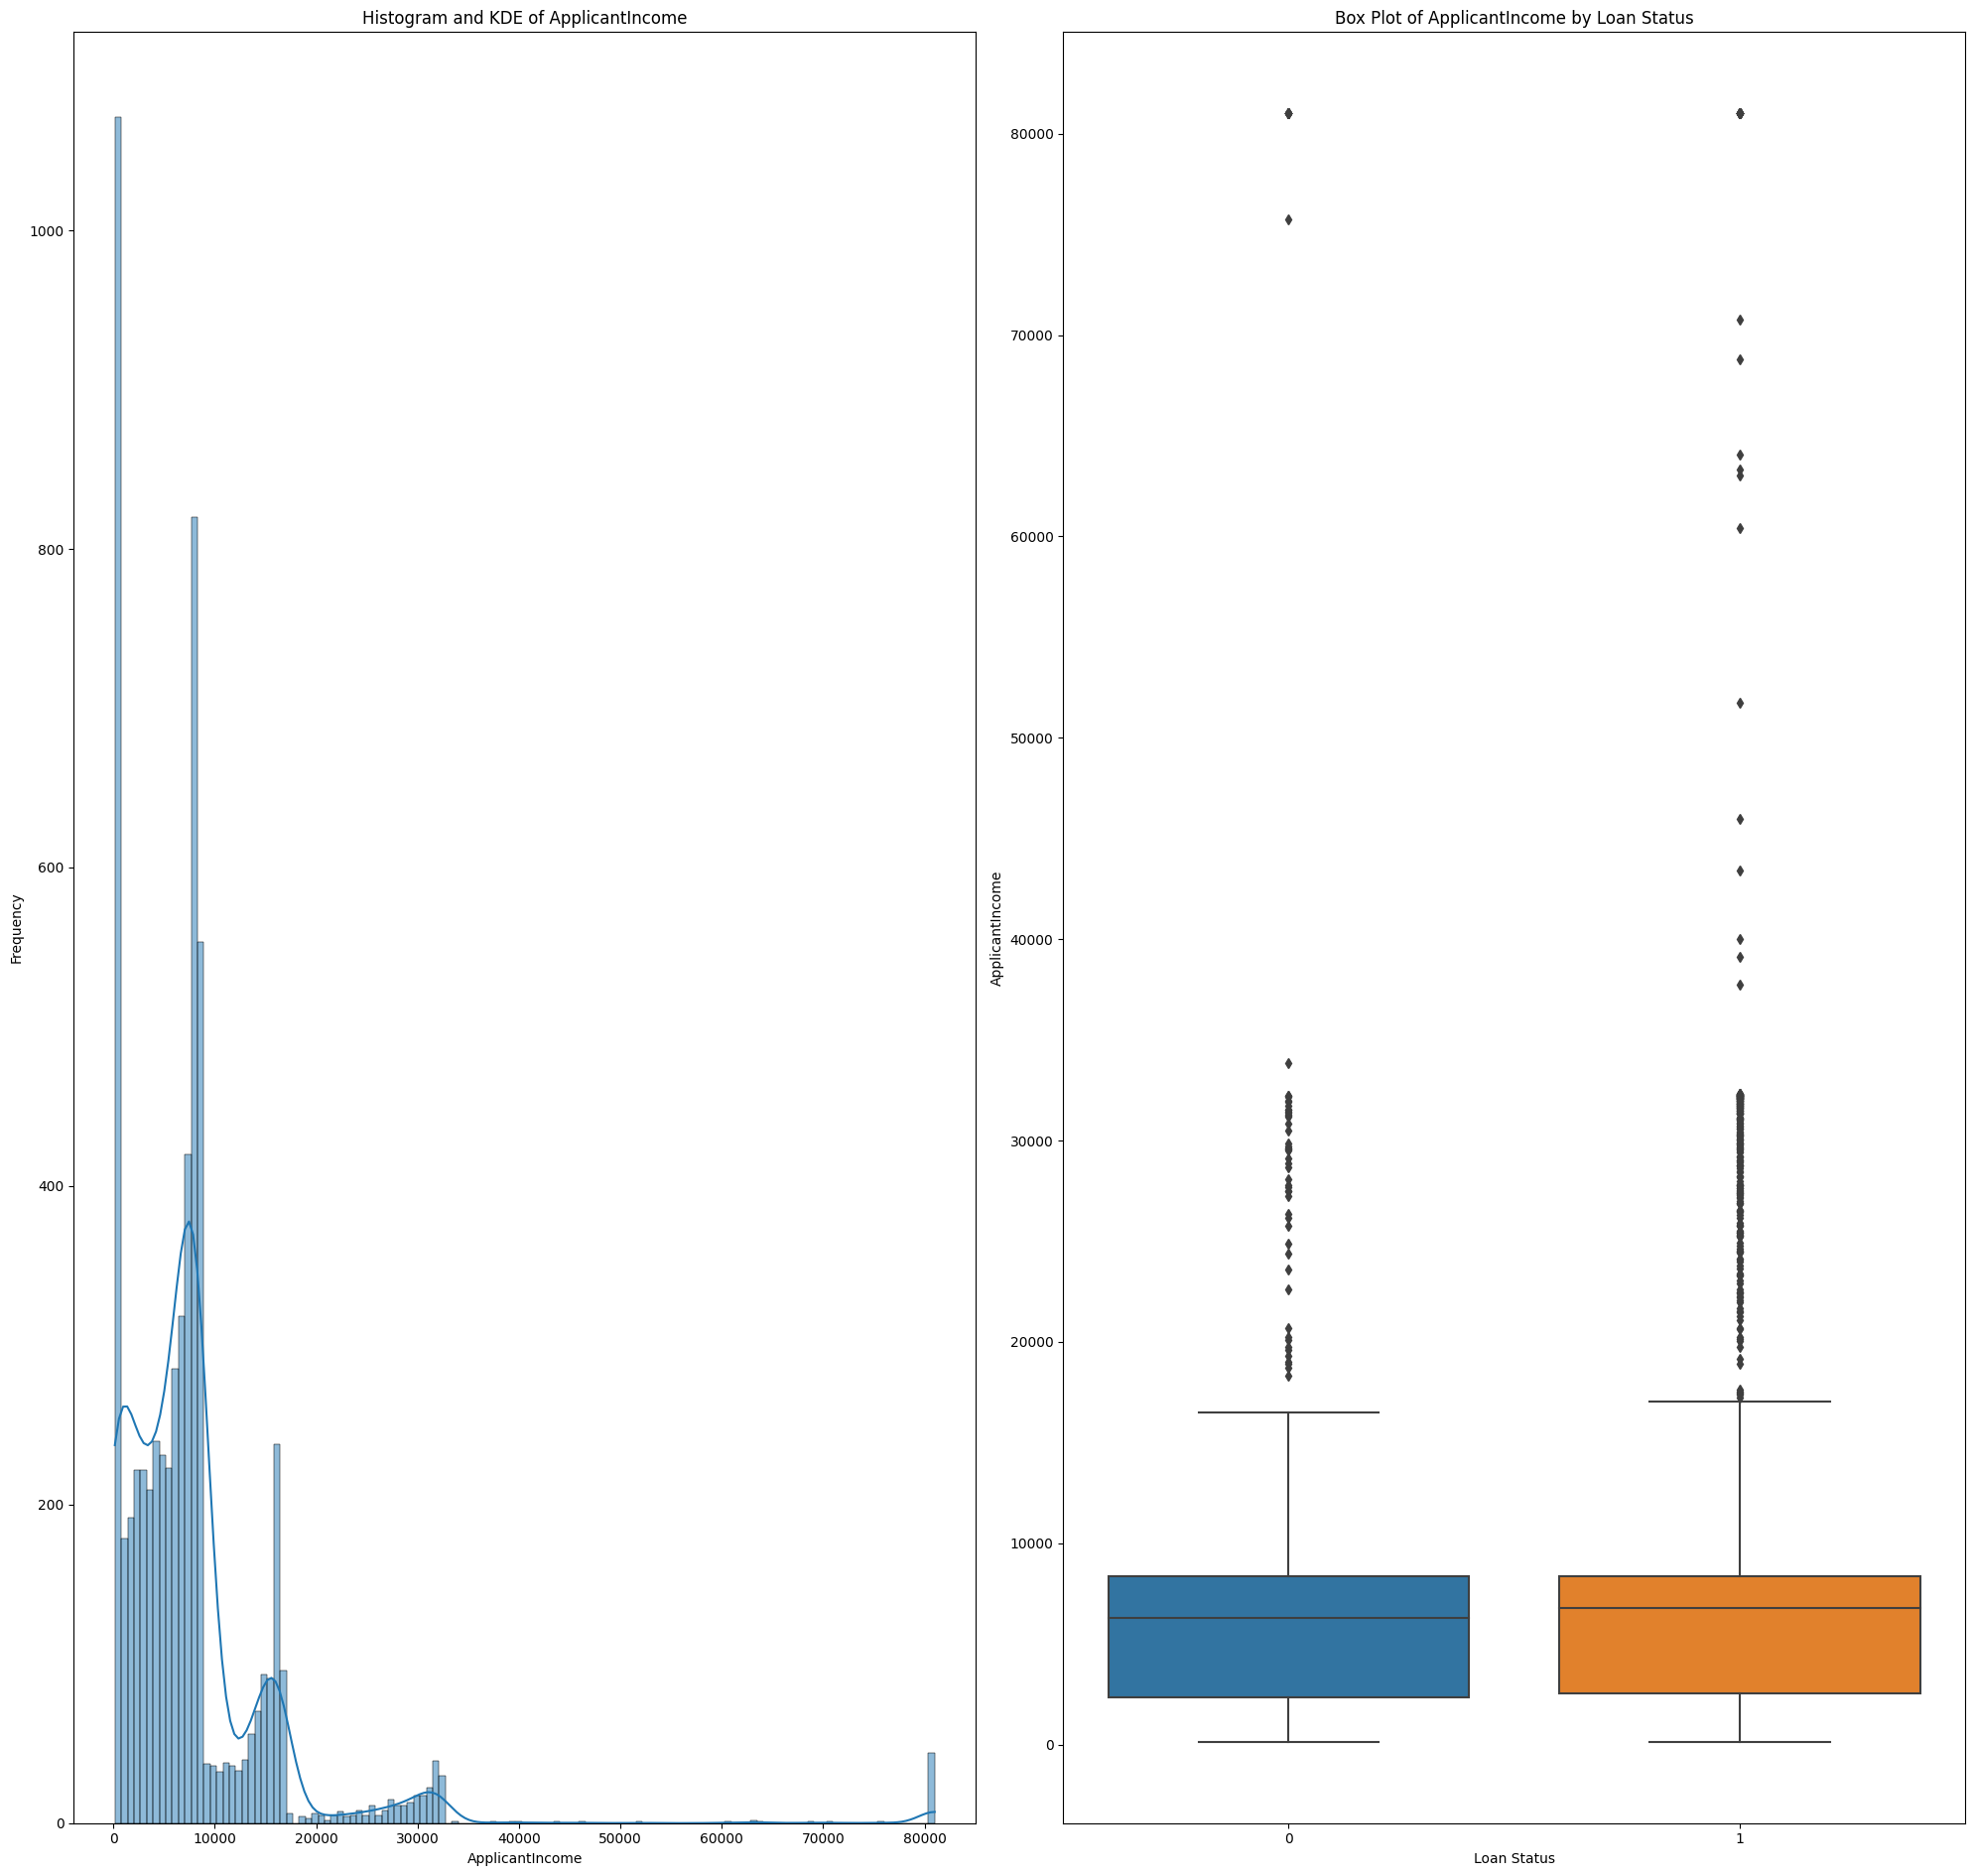

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


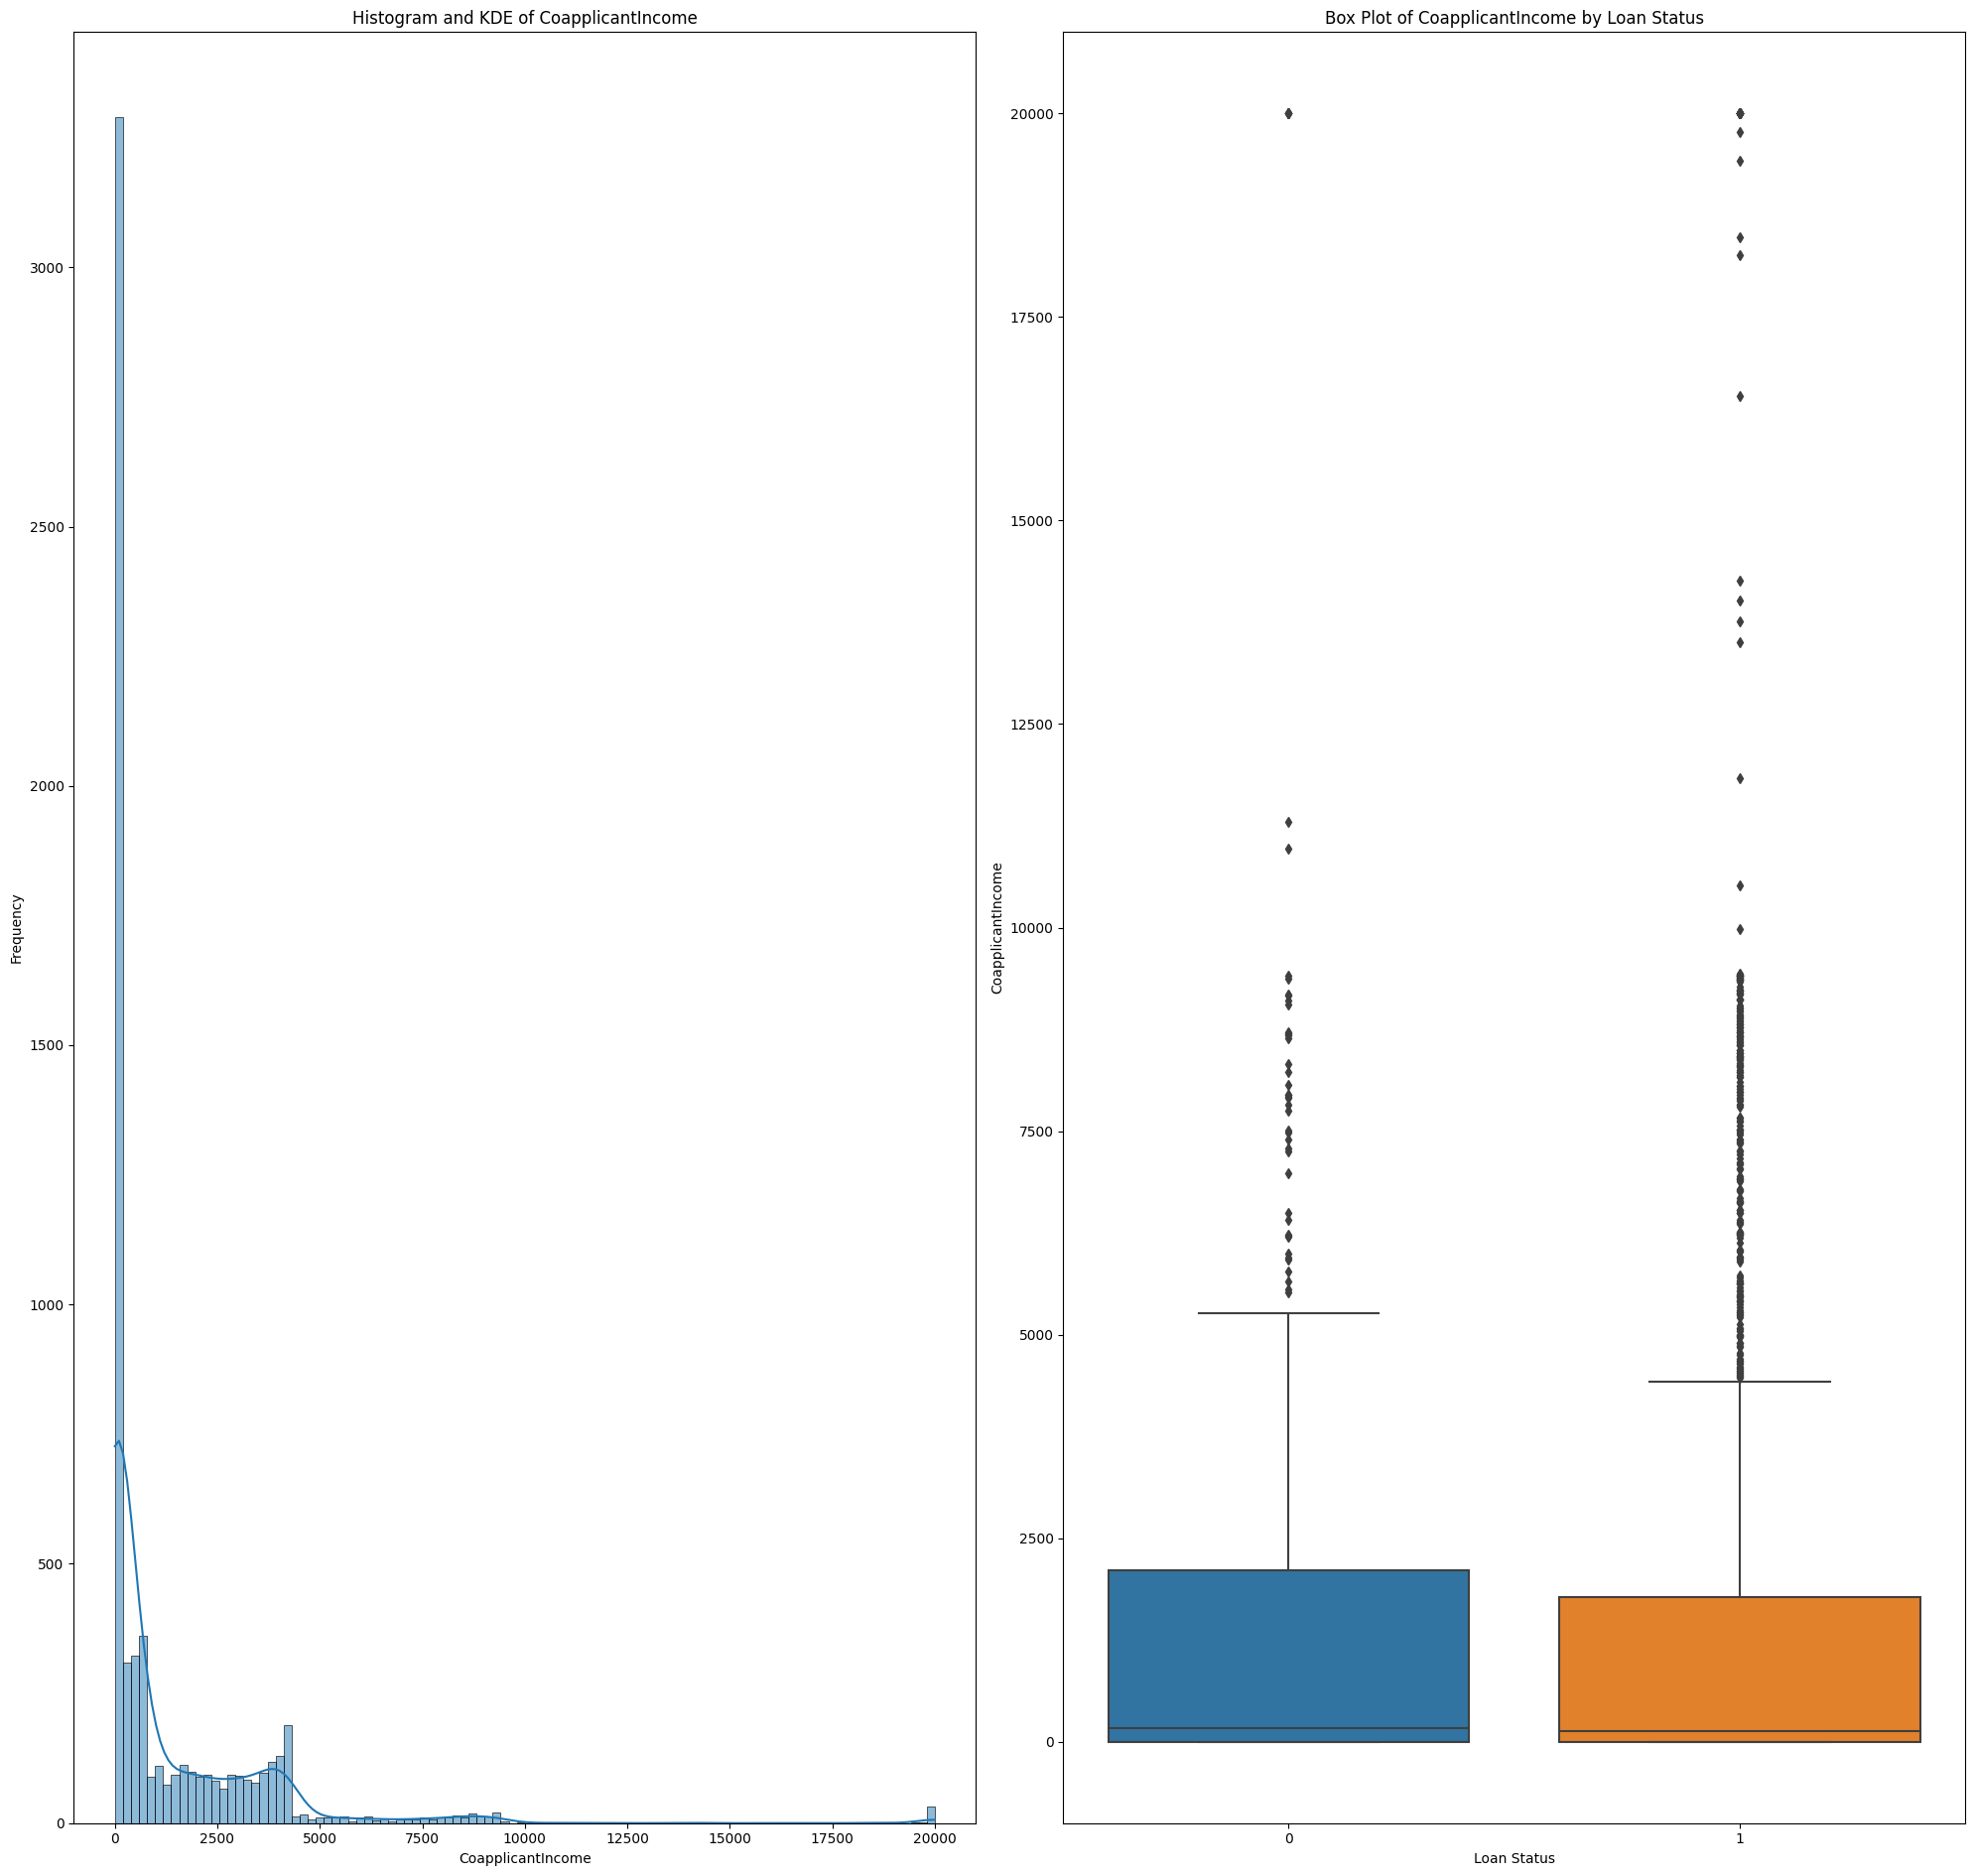

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


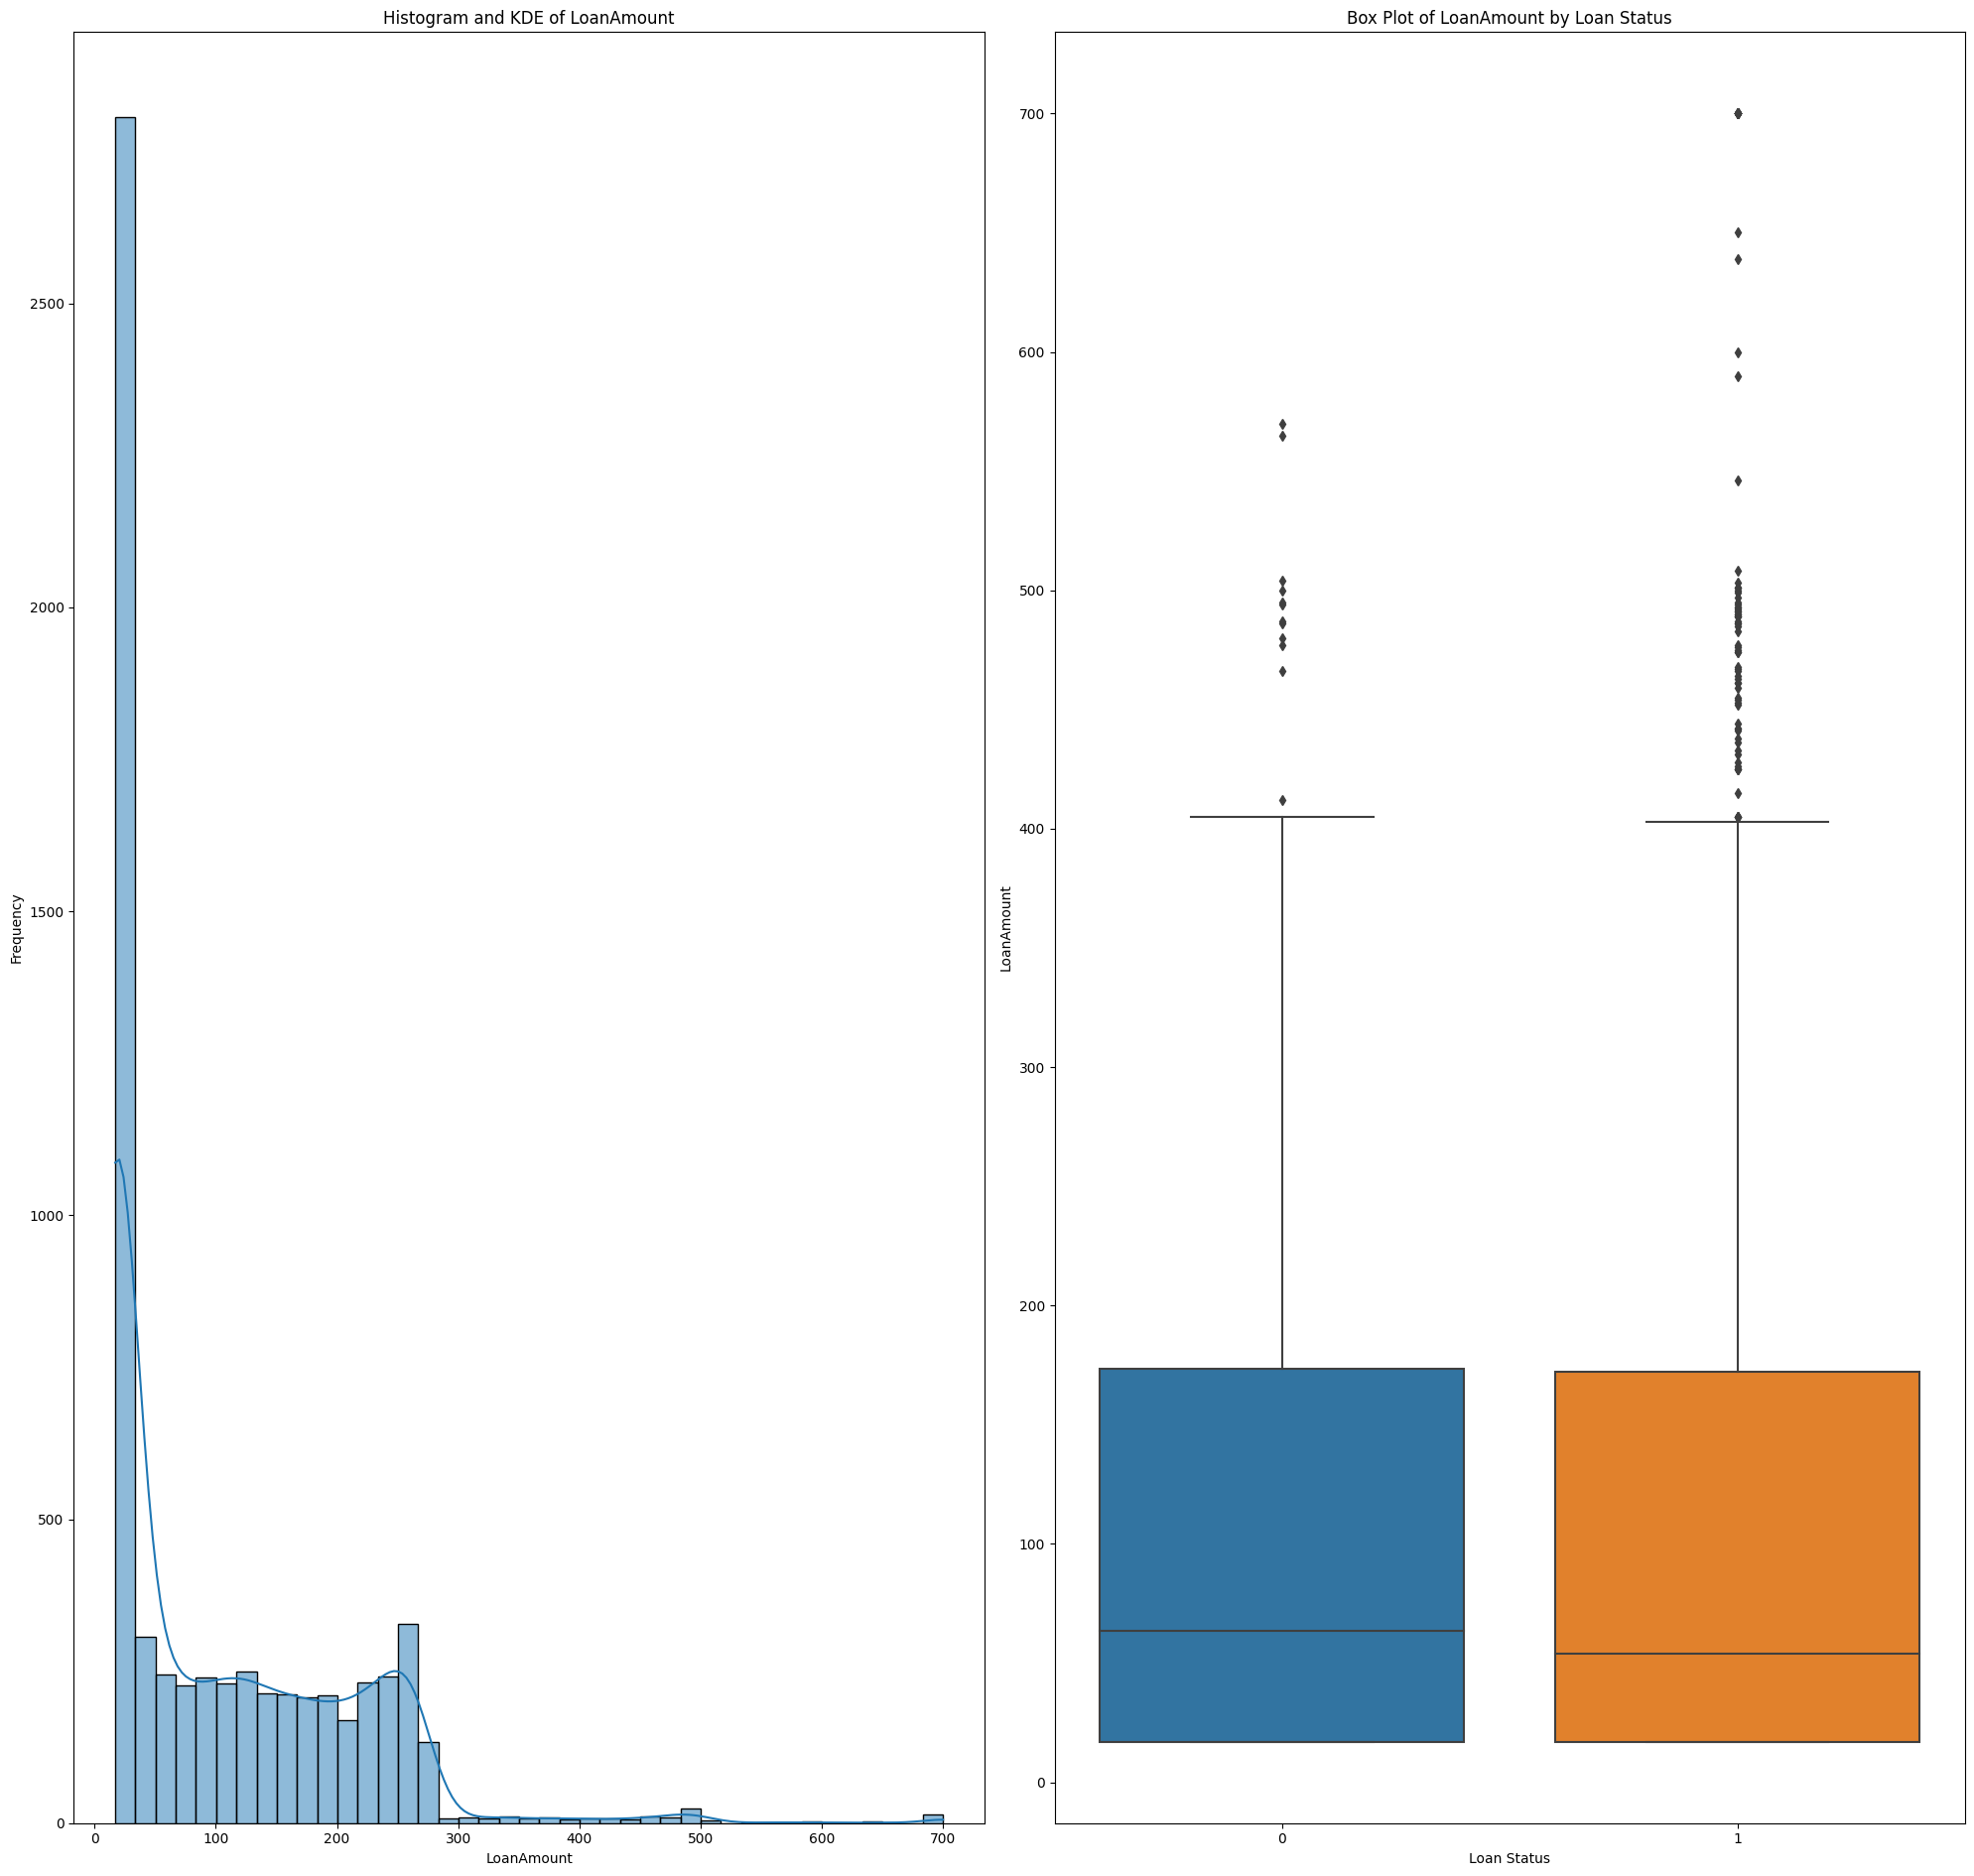

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


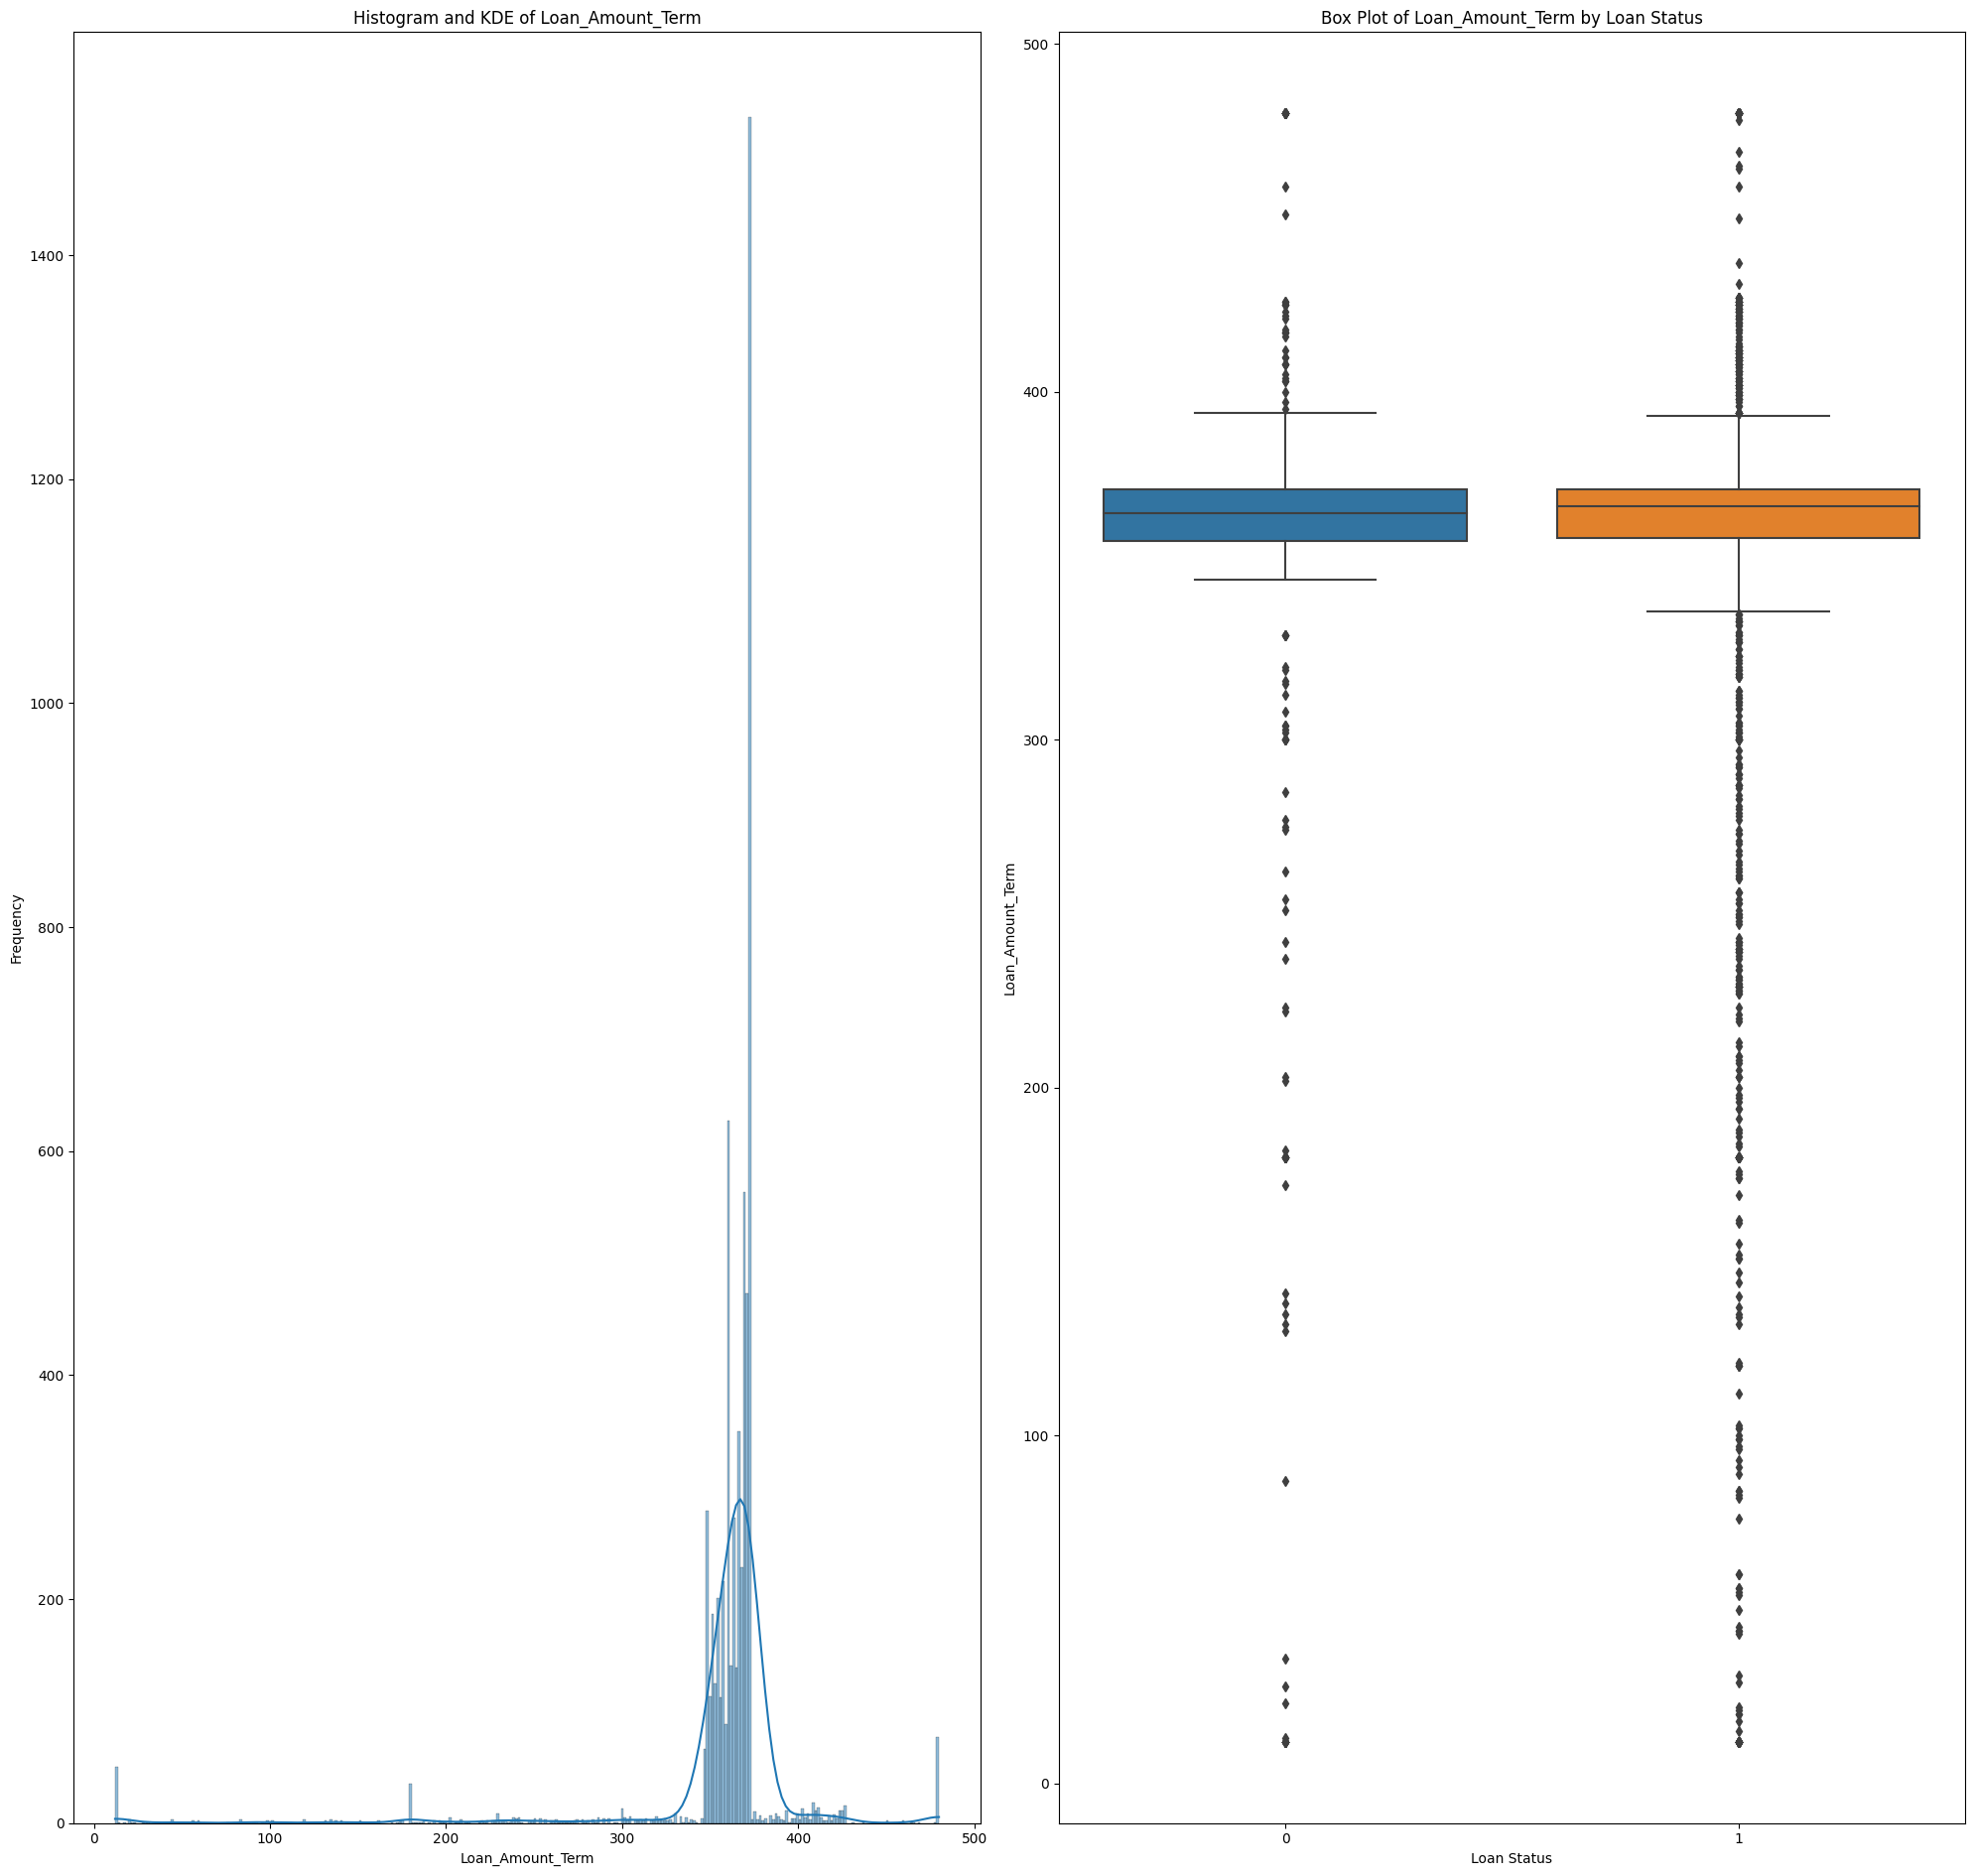

In [36]:
plot_cont(train_csv,cont_var)

In [37]:
cat_var=['Gender','Married','Education', 'Self_Employed','Credit_History','Property_Area','Dependents']

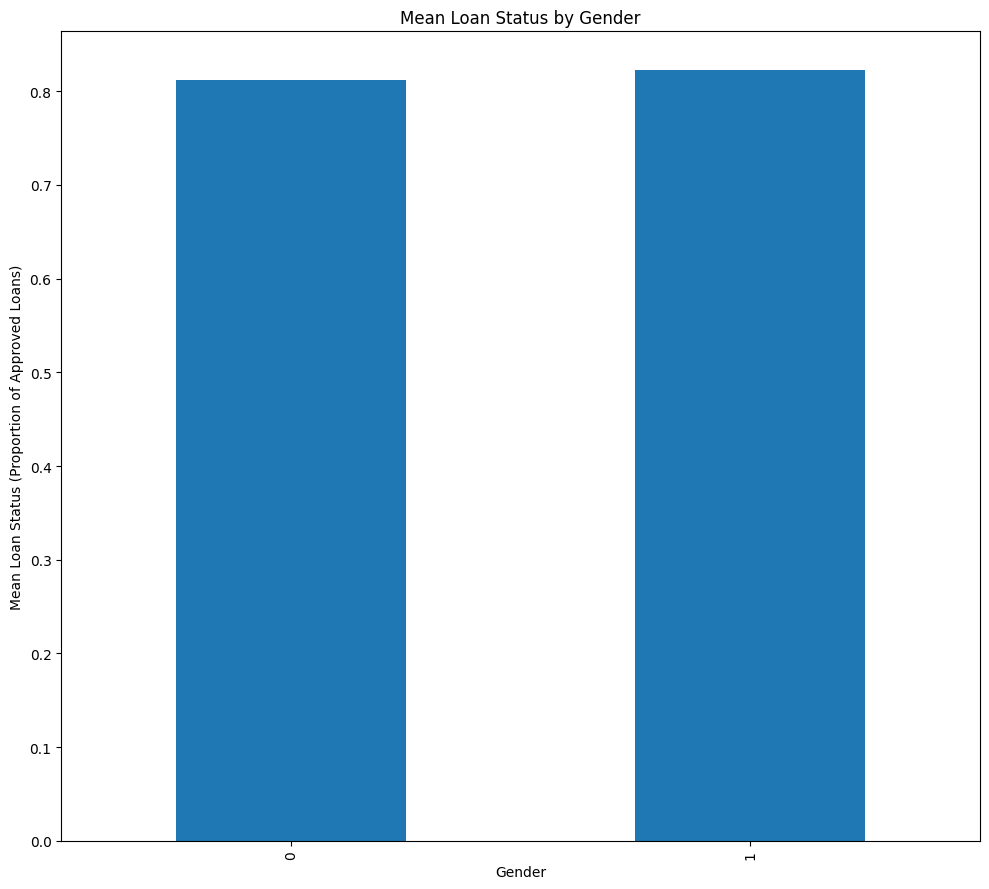

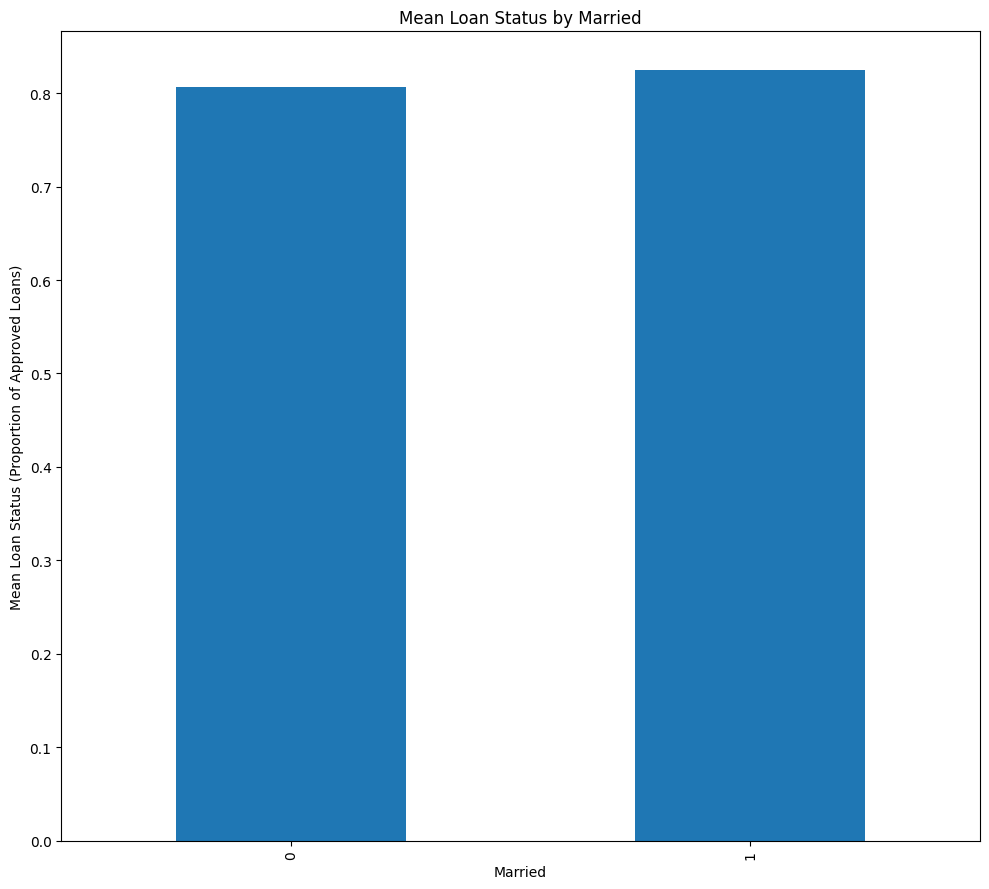

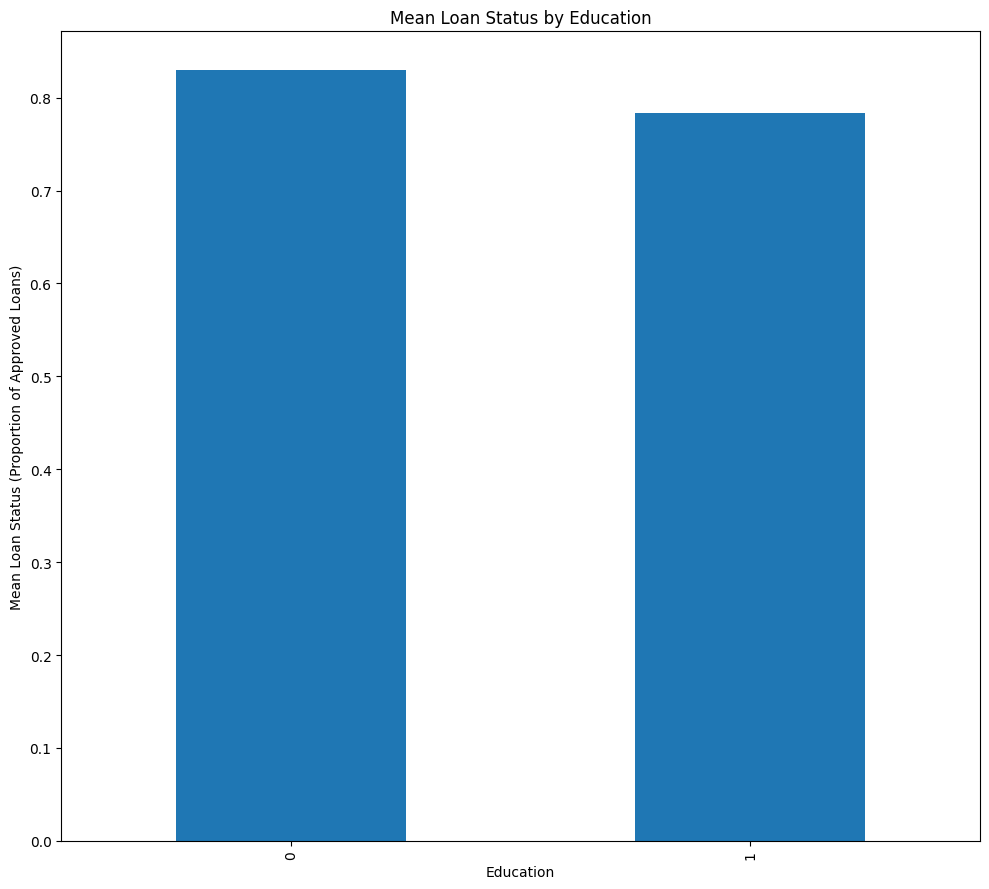

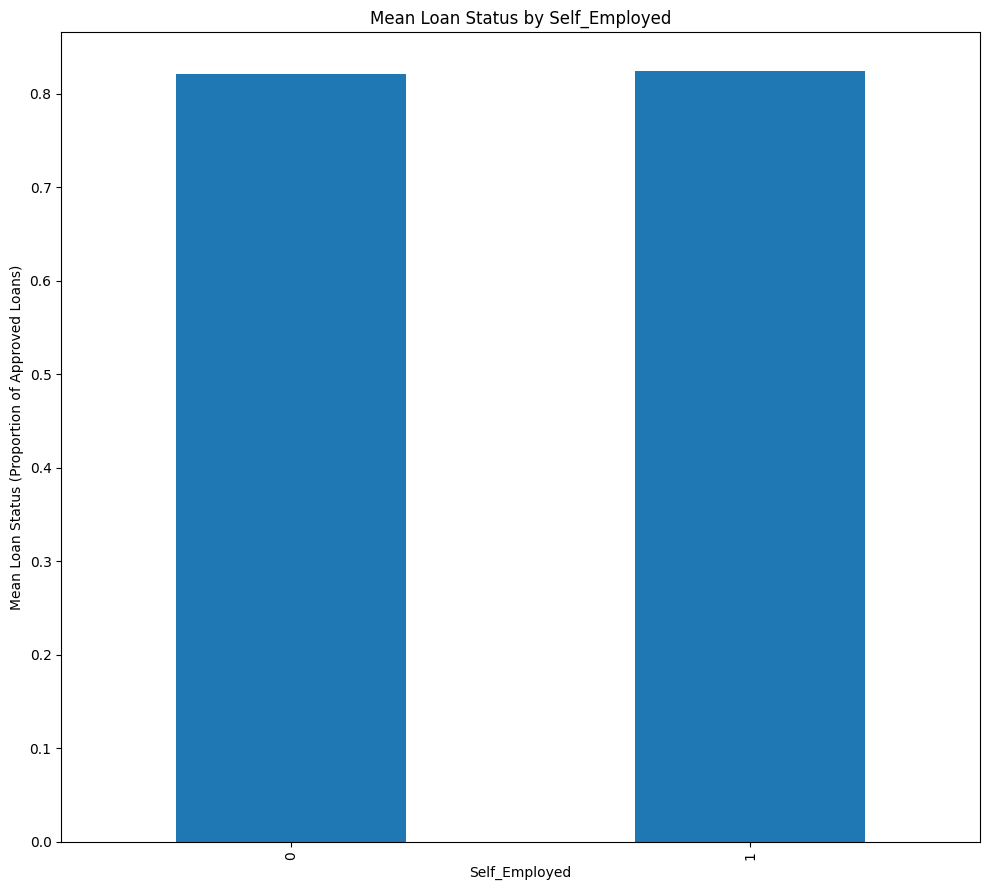

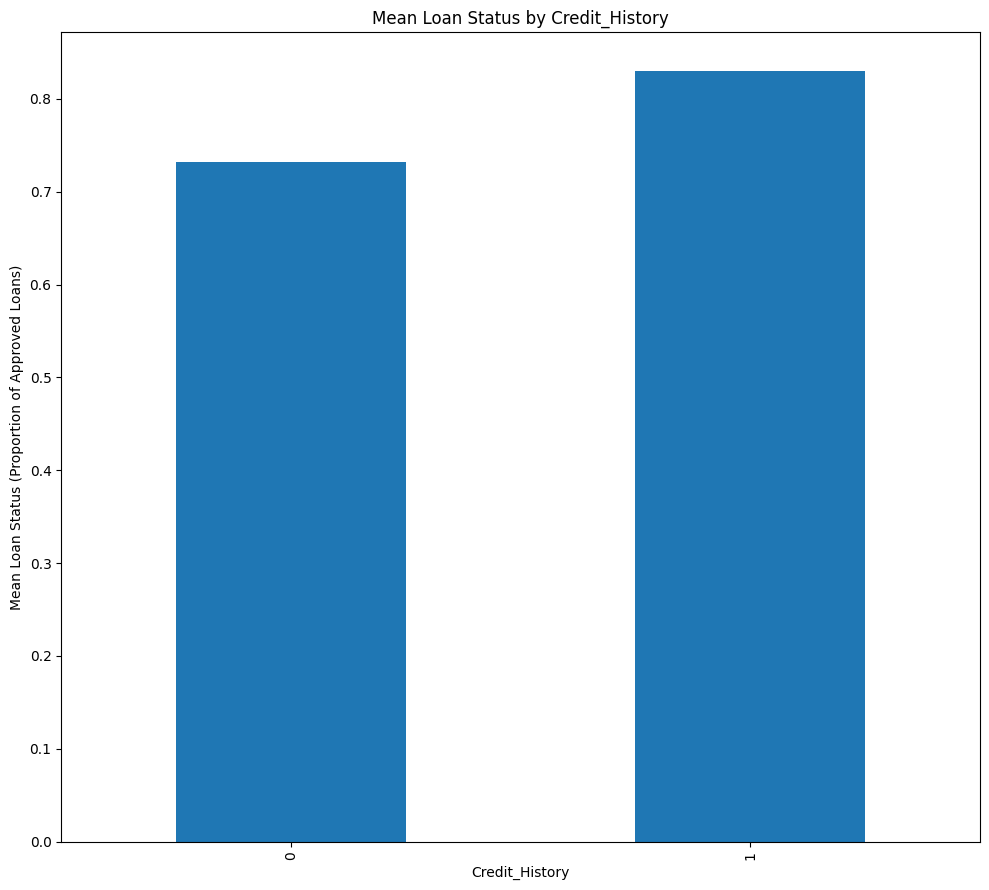

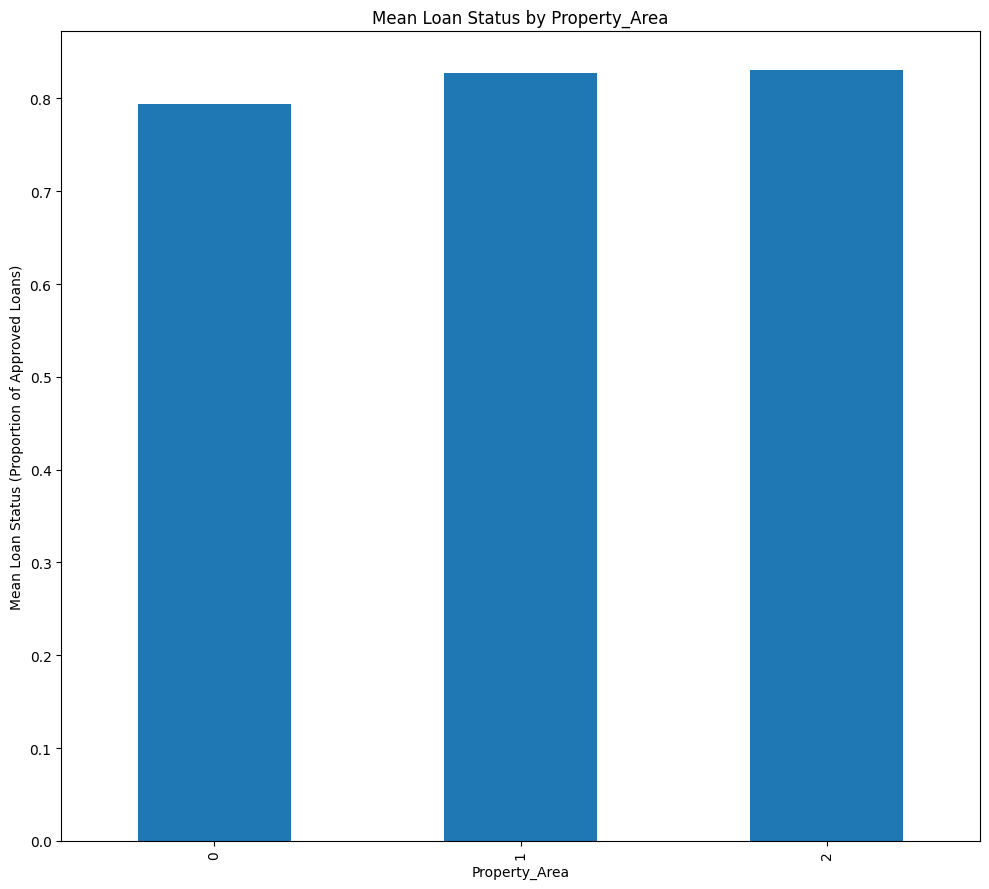

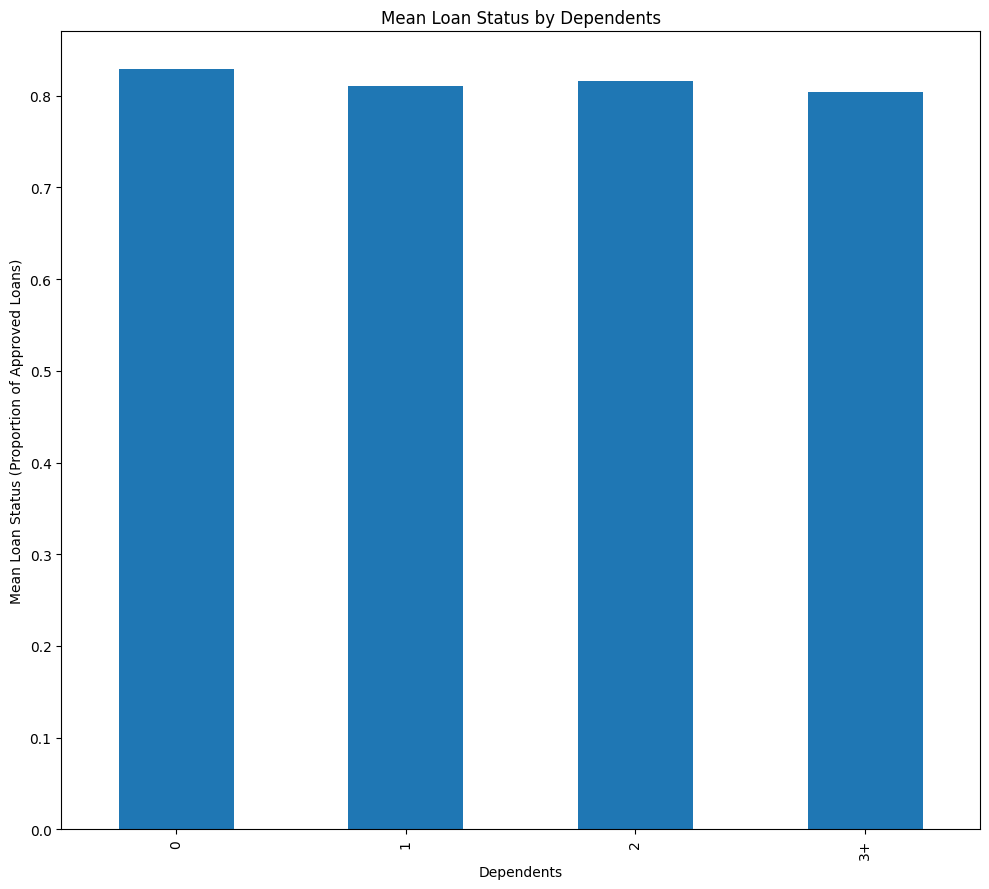

In [38]:
for features in cat_var:
    train_csv.groupby(features)['Loan_Status'].mean().plot(kind='bar',figsize=(10,9))
    plt.title(f'Mean Loan Status by {features}')
    plt.xlabel(features)
    plt.ylabel('Mean Loan Status (Proportion of Approved Loans)')
    
    plt.tight_layout()  
    plt.show()  

    

**Checking Imbalance Data**

([<matplotlib.patches.Wedge at 0x7ce311e22c20>,
 [Text(-0.9321143093802019, 0.5840915289992397, '0'),
  Text(0.9321142820369032, -0.5840915726346587, '1')],
 [Text(-0.5084259869346555, 0.3185953794541307, '82.2%'),
  Text(0.508425972020129, -0.31859540325526836, '17.8%')])

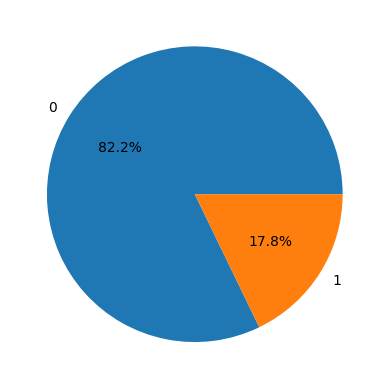

In [39]:
count_class=train_csv['Loan_Status'].value_counts()
plt.pie(labels=[0,1],x=count_class,autopct='%1.1f%%' )

In [40]:
train_csv.drop(columns=['Loan_ID'],inplace=True)

In [41]:
train_csv=pd.get_dummies(train_csv,columns=['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area'])

In [42]:
train_csv

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,Gender_0,Gender_1,Married_0,Married_1,...,Dependents_3+,Education_0,Education_1,Self_Employed_0,Self_Employed_1,Credit_History_0,Credit_History_1,Property_Area_0,Property_Area_1,Property_Area_2
0,8328,0.000000,17.0,363.0,1,6000.0,False,True,False,True,...,False,False,True,True,False,False,True,False,False,True
1,150,3857.458782,188.0,370.0,0,6000.0,False,True,False,True,...,False,True,False,True,False,False,True,False,True,False
2,4989,314.472511,17.0,348.0,0,6000.0,True,False,True,False,...,False,True,False,True,False,False,True,True,False,False
3,150,0.000000,232.0,359.0,1,3750.0,False,True,False,True,...,False,True,False,True,False,False,True,False,True,False
4,8059,0.000000,17.0,372.0,1,3750.0,False,True,False,True,...,False,True,False,True,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3326,913.000000,105.0,84.0,1,4239.0,True,False,False,True,...,False,False,True,True,False,False,True,False,True,False
496,2600,1700.000000,107.0,360.0,1,4300.0,False,True,False,True,...,False,True,False,True,False,False,True,True,False,False
497,4625,2857.000000,111.0,12.0,1,7482.0,False,True,False,True,...,False,False,True,True,False,False,True,False,False,True
498,2895,0.000000,95.0,360.0,1,2895.0,False,True,False,True,...,False,False,True,False,True,False,True,False,True,False


# **Feature Engineering**

In [43]:
train_csv['calculated_Income']=train_csv['ApplicantIncome']+train_csv['CoapplicantIncome']
train_csv

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,Gender_0,Gender_1,Married_0,Married_1,...,Education_0,Education_1,Self_Employed_0,Self_Employed_1,Credit_History_0,Credit_History_1,Property_Area_0,Property_Area_1,Property_Area_2,calculated_Income
0,8328,0.000000,17.0,363.0,1,6000.0,False,True,False,True,...,False,True,True,False,False,True,False,False,True,8328.000000
1,150,3857.458782,188.0,370.0,0,6000.0,False,True,False,True,...,True,False,True,False,False,True,False,True,False,4007.458782
2,4989,314.472511,17.0,348.0,0,6000.0,True,False,True,False,...,True,False,True,False,False,True,True,False,False,5303.472511
3,150,0.000000,232.0,359.0,1,3750.0,False,True,False,True,...,True,False,True,False,False,True,False,True,False,150.000000
4,8059,0.000000,17.0,372.0,1,3750.0,False,True,False,True,...,True,False,True,False,False,True,True,False,False,8059.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3326,913.000000,105.0,84.0,1,4239.0,True,False,False,True,...,False,True,True,False,False,True,False,True,False,4239.000000
496,2600,1700.000000,107.0,360.0,1,4300.0,False,True,False,True,...,True,False,True,False,False,True,True,False,False,4300.000000
497,4625,2857.000000,111.0,12.0,1,7482.0,False,True,False,True,...,False,True,True,False,False,True,False,False,True,7482.000000
498,2895,0.000000,95.0,360.0,1,2895.0,False,True,False,True,...,False,True,False,True,False,True,False,True,False,2895.000000


In [44]:
train_csv

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,Gender_0,Gender_1,Married_0,Married_1,...,Education_0,Education_1,Self_Employed_0,Self_Employed_1,Credit_History_0,Credit_History_1,Property_Area_0,Property_Area_1,Property_Area_2,calculated_Income
0,8328,0.000000,17.0,363.0,1,6000.0,False,True,False,True,...,False,True,True,False,False,True,False,False,True,8328.000000
1,150,3857.458782,188.0,370.0,0,6000.0,False,True,False,True,...,True,False,True,False,False,True,False,True,False,4007.458782
2,4989,314.472511,17.0,348.0,0,6000.0,True,False,True,False,...,True,False,True,False,False,True,True,False,False,5303.472511
3,150,0.000000,232.0,359.0,1,3750.0,False,True,False,True,...,True,False,True,False,False,True,False,True,False,150.000000
4,8059,0.000000,17.0,372.0,1,3750.0,False,True,False,True,...,True,False,True,False,False,True,True,False,False,8059.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3326,913.000000,105.0,84.0,1,4239.0,True,False,False,True,...,False,True,True,False,False,True,False,True,False,4239.000000
496,2600,1700.000000,107.0,360.0,1,4300.0,False,True,False,True,...,True,False,True,False,False,True,True,False,False,4300.000000
497,4625,2857.000000,111.0,12.0,1,7482.0,False,True,False,True,...,False,True,True,False,False,True,False,False,True,7482.000000
498,2895,0.000000,95.0,360.0,1,2895.0,False,True,False,True,...,False,True,False,True,False,True,False,True,False,2895.000000


In [45]:
train_csv['calculated_inc**2']=train_csv['calculated_Income']**2

In [46]:
train_csv['ApplicantIncome']=np.log(train_csv['ApplicantIncome']+1)
train_csv['CoapplicantIncome']=np.log(train_csv['CoapplicantIncome']+1)
train_csv['LoanAmount']=np.log(train_csv['LoanAmount']+1)
train_csv['Loan_Amount_Term']=np.log(train_csv['Loan_Amount_Term']+1)
train_csv['Total_Income']=np.log(train_csv['Total_Income']+1)
train_csv['calculated_Income']=np.log(train_csv['calculated_Income']+1)
train_csv['calculated_inc**2']=np.log(train_csv['calculated_inc**2']+1)

In [47]:
train_csv.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,calculated_Income,calculated_inc**2
count,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000
mean,8.222888,3.796705,4.063064,5.852687,0.821819,8.517468,8.539212,17.076957
std,1.524647,3.676358,1.104944,0.348268,0.382695,0.340888,1.326272,2.655527
min,5.017280,0.000000,2.890372,2.564949,0.000000,7.274479,5.017280,10.021315
25%,7.824446,0.000000,2.890372,5.883322,1.000000,8.229777,8.246237,16.491950
50%,8.809116,4.898485,4.043051,5.908083,1.000000,8.661899,8.933862,17.867460
75%,9.030855,7.512495,5.153292,5.921578,1.000000,8.699681,9.277929,18.555671
max,11.302217,9.903538,6.552508,6.175867,1.000000,11.302217,11.366927,22.733830


In [48]:
def removeoutliers(data,cont):
    q1=data[cont].quantile(0.25)
    q3=data[cont].quantile(0.75)
    IQR=q3-q1
    lower_bound=q1-1.5*IQR
    upper_bound=q3+4.0*IQR
    filtered_data=data[cont].where((data[cont]>lower_bound)&(data[cont]<upper_bound),other=np.nan)
    return filtered_data

In [49]:
cont_var=['Total_Income','ApplicantIncome', 'CoapplicantIncome','LoanAmount','Loan_Amount_Term','calculated_Income','calculated_inc**2']

In [50]:
for i in cont_var:
    if i=='loan_status':
        continue
    train_csv[i]=removeoutliers(train_csv,i)

In [51]:
train_csv.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,calculated_Income,calculated_inc**2
count,5447.000000,6398.000000,6398.000000,5948.000000,6398.000000,6391.000000,5690.000000,5690.000000
mean,8.775311,3.796705,4.063064,5.905003,0.821819,8.515958,8.931012,17.861667
std,0.819909,3.676358,1.104944,0.030206,0.382695,0.333823,0.741077,1.482452
min,6.018593,0.000000,2.890372,5.826000,0.000000,7.576097,6.699500,13.396538
25%,8.402343,0.000000,2.890372,5.888878,1.000000,8.229777,8.543175,17.085960
50%,8.921991,4.898485,4.043051,5.910797,1.000000,8.659213,8.996066,17.991884
75%,9.037296,7.512495,5.153292,5.921578,1.000000,8.699681,9.350690,18.701206
max,11.302217,9.903538,6.552508,6.068426,1.000000,10.537946,11.366927,22.733830


In [52]:
train_csv.isna().sum()

ApplicantIncome      951
CoapplicantIncome      0
LoanAmount             0
Loan_Amount_Term     450
Loan_Status            0
Total_Income           7
Gender_0               0
Gender_1               0
Married_0              0
Married_1              0
Dependents_0           0
Dependents_1           0
Dependents_2           0
Dependents_3+          0
Education_0            0
Education_1            0
Self_Employed_0        0
Self_Employed_1        0
Credit_History_0       0
Credit_History_1       0
Property_Area_0        0
Property_Area_1        0
Property_Area_2        0
calculated_Income    708
calculated_inc**2    708
dtype: int64

In [53]:
train_csv.dropna(inplace=True)

In [54]:
train_csv.drop_duplicates(inplace=True)

In [55]:
print(train_csv.shape)
train_csv.describe()

(4971, 25)


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,calculated_Income,calculated_inc**2
count,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000
mean,8.798143,3.917046,3.980199,5.904337,0.822772,8.517827,8.982337,17.964346
std,0.782794,3.671326,1.084607,0.030606,0.381900,0.331872,0.705274,1.410811
min,6.018593,0.000000,2.890372,5.826000,0.000000,7.582738,6.699500,13.396538
25%,8.440420,0.000000,2.890372,5.888878,1.000000,8.229777,8.639675,17.278997
50%,8.929303,5.348554,3.828641,5.908083,1.000000,8.663542,9.011402,18.022559
75%,9.037533,7.544982,5.056246,5.921578,1.000000,8.699681,9.384717,18.769265
max,11.302217,9.903538,6.552508,6.068426,1.000000,10.537946,11.366927,22.733830


In [56]:
def kmeans_featureGrouping(data,n_clusters,col,is_train=True,k_scaled=None,k_meansd=None):
    feature=data[col].values.reshape(-1,1)
    k_scale=RobustScaler()
    if is_train==True:
        feature=k_scale.fit_transform(feature)
        kmeans=KMeans(random_state=42,n_clusters=n_clusters)
        cluster=kmeans.fit_predict(feature)
        return cluster,k_scale,kmeans
    else:
        feature=k_scaled.transform(feature)
        cluster=k_meansd.predict(feature)
        
        return cluster

In [57]:
cluster_appinc,scale_appinc,kmeans_appinc=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='ApplicantIncome',is_train=True)
print(cluster_appinc[:10])

[0 0 0 1 0 1 2 0 2 2]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [58]:
cluster_co_appinc,scale_co_appinc,kmeans_co_appinc=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='CoapplicantIncome',is_train=True)
cluster_loanamt,scale_loanamt,kmeans_loanamt=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='LoanAmount',is_train=True)
cluster_lnterm,scale_lnterm,kmeans_lnterm=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='Loan_Amount_Term',is_train=True)
cluster_tinc,scale_tinc,kmeans_tinc=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='Total_Income',is_train=True)
cluster_calinc,scale_calinc,kmeans_calinc=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='calculated_Income',is_train=True)
cluster_calinc2,scale_calinc2,kmeans_calinc2=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='calculated_inc**2',is_train=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [59]:
train_csv['cluster_co_appinc']=cluster_co_appinc
train_csv['cluster_loanamt']=cluster_loanamt
train_csv['cluster_lnterm']=cluster_lnterm
train_csv['cluster_tinc']=cluster_tinc
train_csv['cluster_calinc']=cluster_calinc
train_csv['cluster_calinc2']=cluster_calinc2
train_csv['cluster_appinc']=cluster_appinc
train_csv

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,Gender_0,Gender_1,Married_0,Married_1,...,Property_Area_2,calculated_Income,calculated_inc**2,cluster_co_appinc,cluster_loanamt,cluster_lnterm,cluster_tinc,cluster_calinc,cluster_calinc2,cluster_appinc
0,9.027499,0.000000,2.890372,5.897154,1,8.699681,False,True,False,True,...,True,9.027499,18.054757,0,1,1,1,1,1,0
2,8.515191,5.754072,2.890372,5.855072,0,8.699681,True,False,True,False,...,False,8.576306,17.152234,2,1,0,1,1,1,0
4,8.994669,0.000000,2.890372,5.921578,1,8.229777,False,True,False,True,...,False,8.994669,17.989090,0,1,1,0,1,1,0
5,7.555905,8.330014,4.189655,5.924256,1,8.699681,True,False,False,True,...,True,8.709049,17.417767,1,0,1,1,1,1,1
6,8.870944,6.832807,2.890372,6.054439,1,8.699681,False,True,False,True,...,False,8.993277,17.986306,2,1,2,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,9.756379,0.000000,5.420535,5.888878,1,9.756379,True,False,True,False,...,False,9.756379,19.512642,0,2,0,2,0,0,2
494,8.188133,7.676937,4.787492,5.888878,0,8.657825,False,True,False,True,...,False,8.657824,17.315301,1,0,0,1,1,1,1
496,7.863651,7.438972,4.682131,5.888878,1,8.366603,False,True,False,True,...,False,8.366603,16.732741,1,0,0,0,2,2,1
498,7.971086,0.000000,4.564348,5.888878,1,7.971086,False,True,False,True,...,False,7.971086,15.941481,0,0,0,0,2,2,1


# **Interaction Effect**

In [60]:
train_csv['loan_app*loan_coapp']=train_csv['ApplicantIncome']*train_csv['CoapplicantIncome']

In [61]:
train_csv['Loan_Income_Ratio']=train_csv['LoanAmount']/train_csv['calculated_Income']
train_csv['Coapp_ratio']=train_csv['CoapplicantIncome']/train_csv['calculated_Income']

In [62]:
cluster_lnapp,scale_lnapp,kmeans_lnapp=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='loan_app*loan_coapp',is_train=True)
cluster_lnratio,scale_lnratio,kmeans_lnratio=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='Loan_Income_Ratio',is_train=True)
cluster_coratio,scale_coratio,kmeans_coratio=kmeans_featureGrouping(data=train_csv,n_clusters=3,col='Coapp_ratio',is_train=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [63]:
train_csv['cluster_lnapp']=cluster_lnapp
train_csv['cluster_lnratio']=cluster_lnratio
train_csv['cluster_coratio']=cluster_coratio

In [64]:
train_csv

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,Gender_0,Gender_1,Married_0,Married_1,...,cluster_tinc,cluster_calinc,cluster_calinc2,cluster_appinc,loan_app*loan_coapp,Loan_Income_Ratio,Coapp_ratio,cluster_lnapp,cluster_lnratio,cluster_coratio
0,9.027499,0.000000,2.890372,5.897154,1,8.699681,False,True,False,True,...,1,1,1,0,0.000000,0.320174,0.000000,0,1,1
2,8.515191,5.754072,2.890372,5.855072,0,8.699681,True,False,True,False,...,1,1,1,0,48.997019,0.337018,0.670927,2,1,0
4,8.994669,0.000000,2.890372,5.921578,1,8.229777,False,True,False,True,...,0,1,1,0,0.000000,0.321343,0.000000,0,1,1
5,7.555905,8.330014,4.189655,5.924256,1,8.699681,True,False,False,True,...,1,1,1,1,62.940799,0.481069,0.956478,1,2,2
6,8.870944,6.832807,2.890372,6.054439,1,8.699681,False,True,False,True,...,1,1,1,0,60.613443,0.321392,0.759768,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,9.756379,0.000000,5.420535,5.888878,1,9.756379,True,False,True,False,...,2,0,0,2,0.000000,0.555589,0.000000,0,0,1
494,8.188133,7.676937,4.787492,5.888878,0,8.657825,False,True,False,True,...,1,1,1,1,62.859786,0.552967,0.886705,1,2,2
496,7.863651,7.438972,4.682131,5.888878,1,8.366603,False,True,False,True,...,0,2,2,1,58.497478,0.559622,0.889127,2,0,2
498,7.971086,0.000000,4.564348,5.888878,1,7.971086,False,True,False,True,...,0,2,2,1,0.000000,0.572613,0.000000,0,0,1


In [65]:
train_csv=pd.get_dummies(train_csv,columns=['cluster_lnterm','cluster_tinc','cluster_calinc','cluster_appinc','cluster_lnapp','cluster_lnratio','cluster_coratio'])
print(train_csv.shape)
train_csv

(4971, 52)


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,Gender_0,Gender_1,Married_0,Married_1,...,cluster_appinc_2,cluster_lnapp_0,cluster_lnapp_1,cluster_lnapp_2,cluster_lnratio_0,cluster_lnratio_1,cluster_lnratio_2,cluster_coratio_0,cluster_coratio_1,cluster_coratio_2
0,9.027499,0.000000,2.890372,5.897154,1,8.699681,False,True,False,True,...,False,True,False,False,False,True,False,False,True,False
2,8.515191,5.754072,2.890372,5.855072,0,8.699681,True,False,True,False,...,False,False,False,True,False,True,False,True,False,False
4,8.994669,0.000000,2.890372,5.921578,1,8.229777,False,True,False,True,...,False,True,False,False,False,True,False,False,True,False
5,7.555905,8.330014,4.189655,5.924256,1,8.699681,True,False,False,True,...,False,False,True,False,False,False,True,False,False,True
6,8.870944,6.832807,2.890372,6.054439,1,8.699681,False,True,False,True,...,False,False,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,9.756379,0.000000,5.420535,5.888878,1,9.756379,True,False,True,False,...,True,True,False,False,True,False,False,False,True,False
494,8.188133,7.676937,4.787492,5.888878,0,8.657825,False,True,False,True,...,False,False,True,False,False,False,True,False,False,True
496,7.863651,7.438972,4.682131,5.888878,1,8.366603,False,True,False,True,...,False,False,False,True,True,False,False,False,False,True
498,7.971086,0.000000,4.564348,5.888878,1,7.971086,False,True,False,True,...,False,True,False,False,True,False,False,False,True,False


In [66]:
train_csv.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Loan_Status', 'Total_Income', 'Gender_0',
       'Gender_1', 'Married_0', 'Married_1', 'Dependents_0', 'Dependents_1',
       'Dependents_2', 'Dependents_3+', 'Education_0', 'Education_1',
       'Self_Employed_0', 'Self_Employed_1', 'Credit_History_0',
       'Credit_History_1', 'Property_Area_0', 'Property_Area_1',
       'Property_Area_2', 'calculated_Income', 'calculated_inc**2',
       'cluster_co_appinc', 'cluster_loanamt', 'cluster_calinc2',
       'loan_app*loan_coapp', 'Loan_Income_Ratio', 'Coapp_ratio',
       'cluster_lnterm_0', 'cluster_lnterm_1', 'cluster_lnterm_2',
       'cluster_tinc_0', 'cluster_tinc_1', 'cluster_tinc_2',
       'cluster_calinc_0', 'cluster_calinc_1', 'cluster_calinc_2',
       'cluster_appinc_0', 'cluster_appinc_1', 'cluster_appinc_2',
       'cluster_lnapp_0', 'cluster_lnapp_1', 'cluster_lnapp_2',
       'cluster_lnratio_0', 'cluster_lnratio_1', 'cluster_lnratio_

<Axes: >

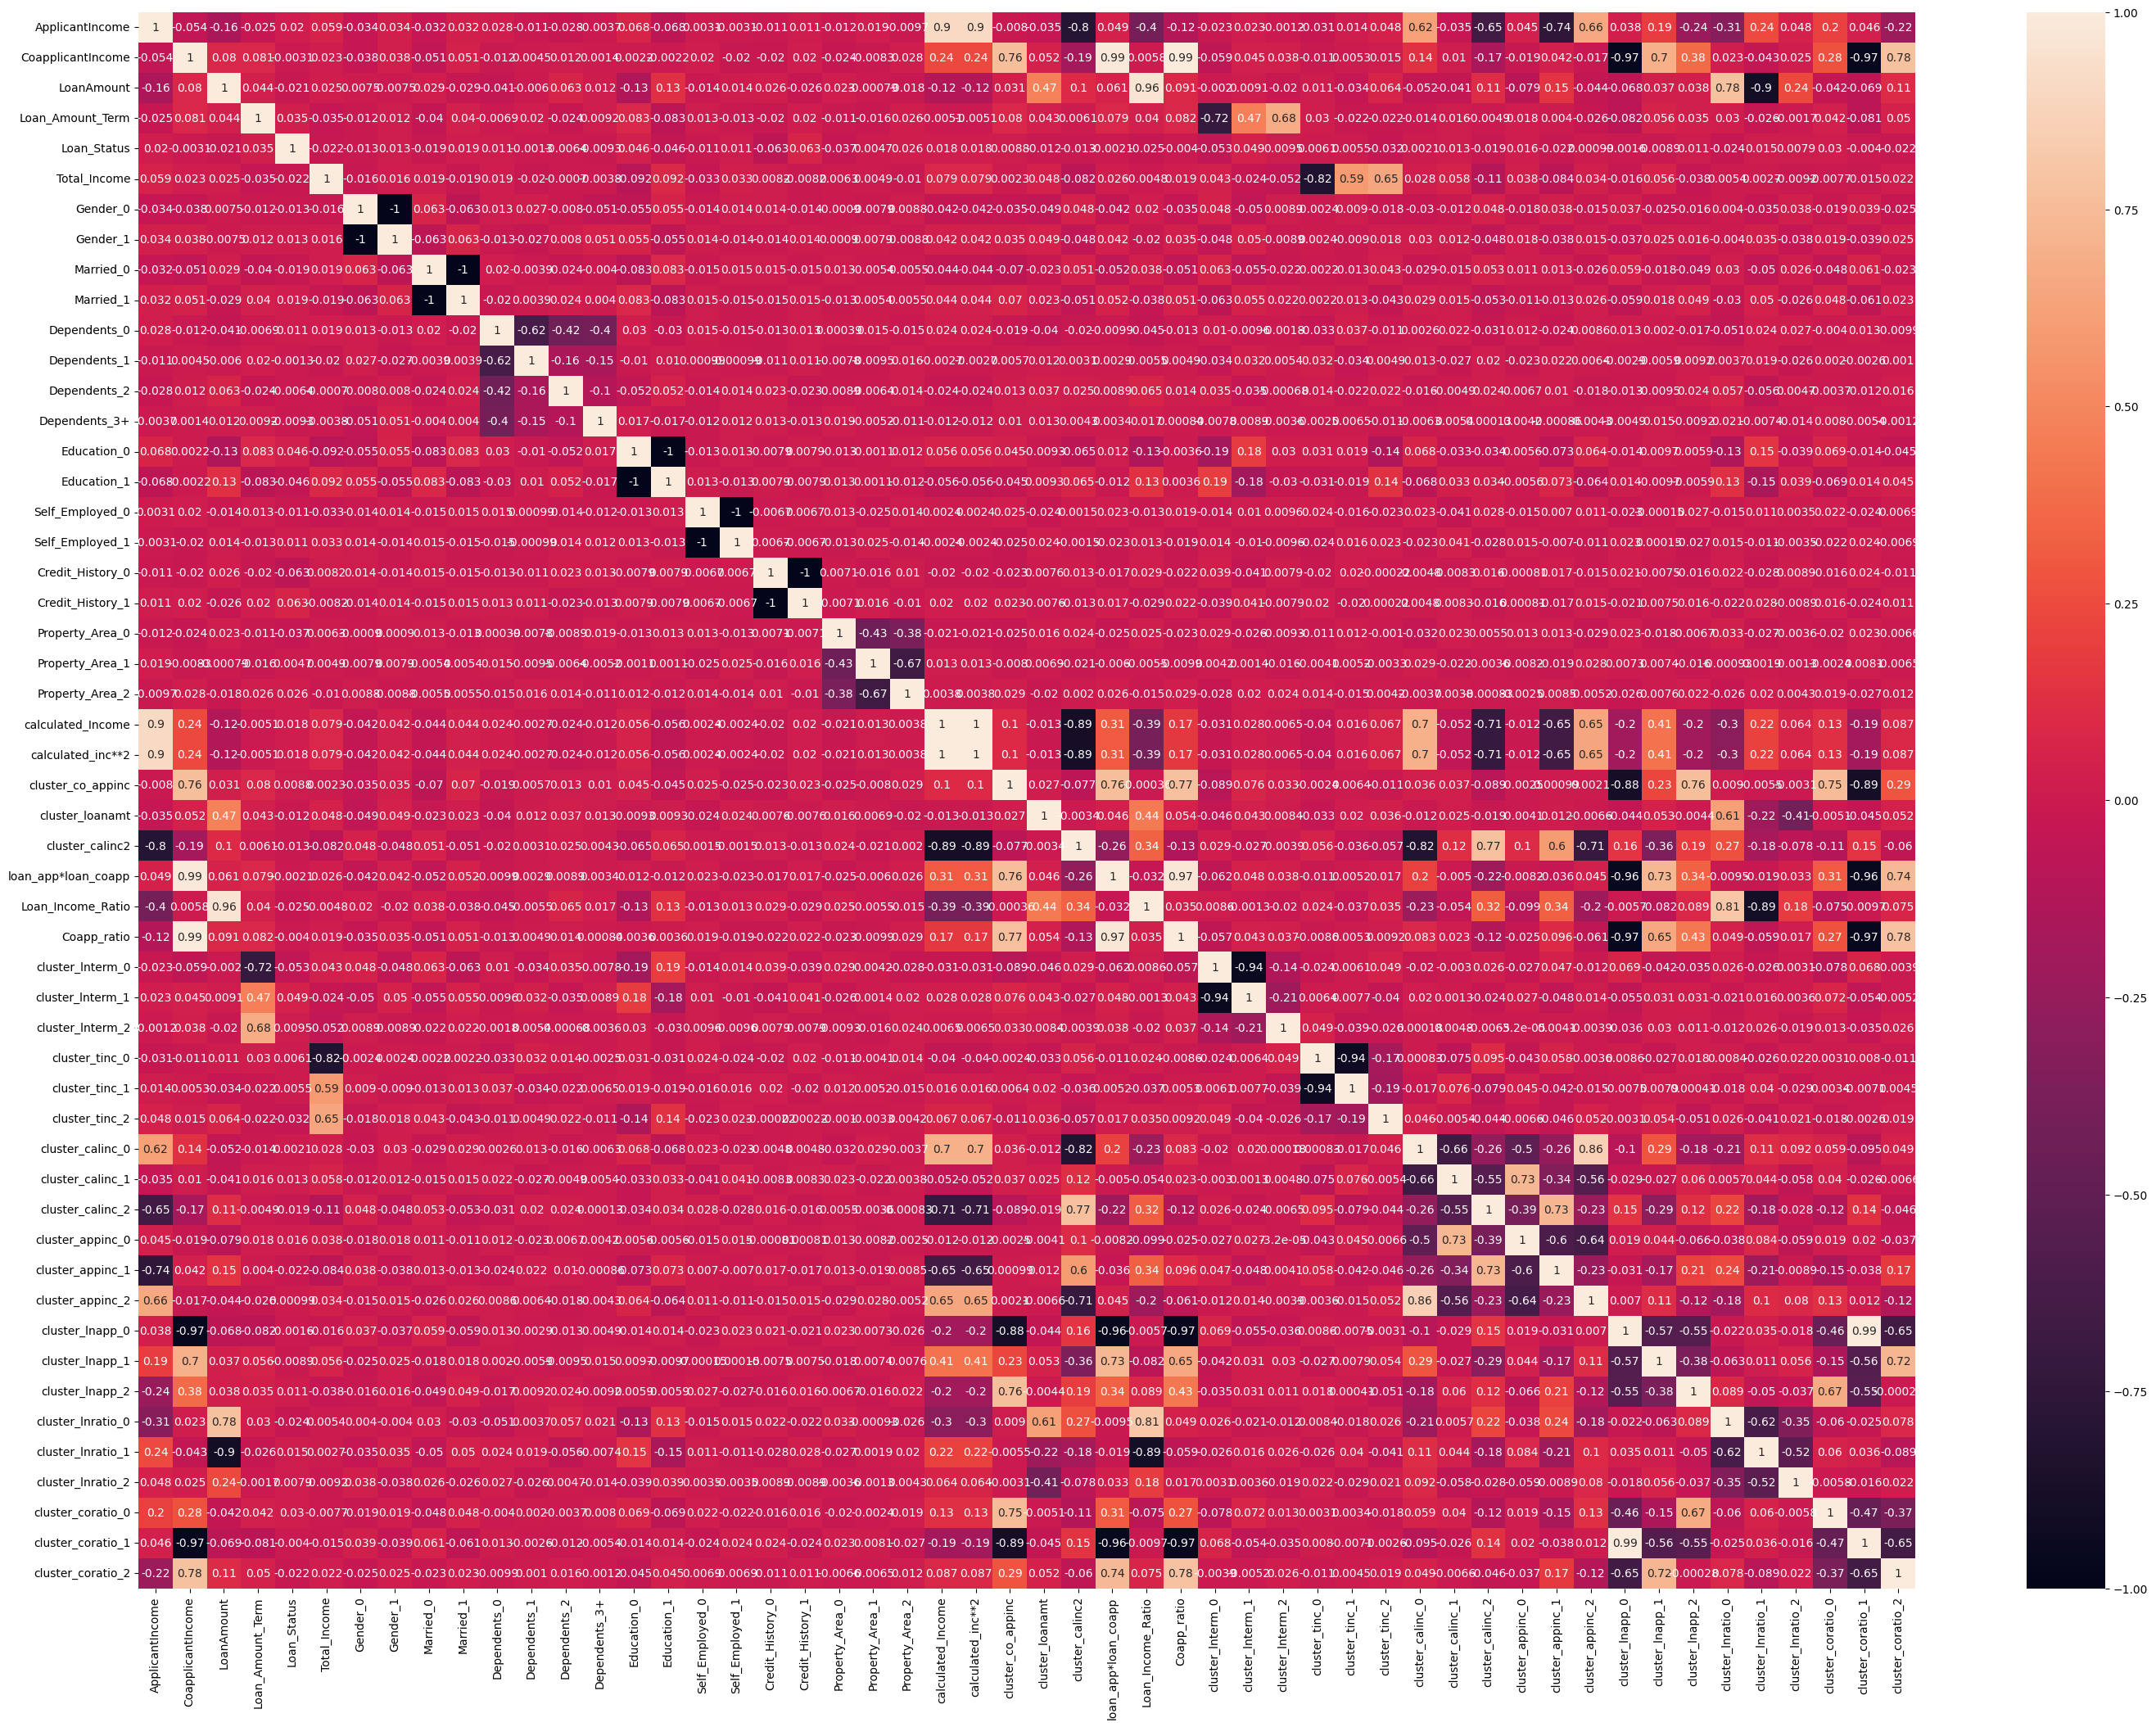

In [67]:
plt.figure(figsize=(35,25))
matrices=train_csv.corr()
sns.heatmap(matrices,annot=True)

In [68]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4971 entries, 0 to 499
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ApplicantIncome      4971 non-null   float64
 1   CoapplicantIncome    4971 non-null   float64
 2   LoanAmount           4971 non-null   float64
 3   Loan_Amount_Term     4971 non-null   float64
 4   Loan_Status          4971 non-null   int64  
 5   Total_Income         4971 non-null   float32
 6   Gender_0             4971 non-null   bool   
 7   Gender_1             4971 non-null   bool   
 8   Married_0            4971 non-null   bool   
 9   Married_1            4971 non-null   bool   
 10  Dependents_0         4971 non-null   bool   
 11  Dependents_1         4971 non-null   bool   
 12  Dependents_2         4971 non-null   bool   
 13  Dependents_3+        4971 non-null   bool   
 14  Education_0          4971 non-null   bool   
 15  Education_1          4971 non-null   bool   

In [69]:
for i in train_csv.columns:
    if train_csv[i].dtype=='int64':    
        train_csv[i]=train_csv[i].astype('int32')

In [70]:
for i in train_csv.columns:
    if train_csv[i].dtype=='float64':    
        train_csv[i]=train_csv[i].astype('float32')

In [71]:
y_values=train_csv.pop('Loan_Status')

In [72]:
y_values

0      1
2      0
4      1
5      1
6      1
      ..
493    1
494    0
496    1
498    1
499    0
Name: Loan_Status, Length: 4971, dtype: int32

In [73]:
from imblearn.combine import SMOTETomek

In [130]:
smote = SMOTETomek(random_state=42)
x_train_resample, y_train_resample = smote.fit_resample(train_csv, y_values)

In [75]:
train_csv

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Total_Income,Gender_0,Gender_1,Married_0,Married_1,Dependents_0,...,cluster_appinc_2,cluster_lnapp_0,cluster_lnapp_1,cluster_lnapp_2,cluster_lnratio_0,cluster_lnratio_1,cluster_lnratio_2,cluster_coratio_0,cluster_coratio_1,cluster_coratio_2
0,9.027498,0.000000,2.890372,5.897154,8.699681,False,True,False,True,True,...,False,True,False,False,False,True,False,False,True,False
2,8.515191,5.754072,2.890372,5.855072,8.699681,True,False,True,False,True,...,False,False,False,True,False,True,False,True,False,False
4,8.994669,0.000000,2.890372,5.921578,8.229777,False,True,False,True,False,...,False,True,False,False,False,True,False,False,True,False
5,7.555905,8.330014,4.189655,5.924256,8.699681,True,False,False,True,True,...,False,False,True,False,False,False,True,False,False,True
6,8.870944,6.832807,2.890372,6.054440,8.699681,False,True,False,True,False,...,False,False,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,9.756379,0.000000,5.420535,5.888878,9.756379,True,False,True,False,True,...,True,True,False,False,True,False,False,False,True,False
494,8.188133,7.676937,4.787492,5.888878,8.657825,False,True,False,True,True,...,False,False,True,False,False,False,True,False,False,True
496,7.863651,7.438972,4.682131,5.888878,8.366603,False,True,False,True,True,...,False,False,False,True,True,False,False,False,False,True
498,7.971086,0.000000,4.564348,5.888878,7.971086,False,True,False,True,False,...,False,True,False,False,True,False,False,False,True,False


In [231]:
x_train=train_csv.copy(deep=True)

In [232]:
print(x_train.shape)
x_train.describe()

(4971, 51)


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Total_Income,calculated_Income,calculated_inc**2,cluster_co_appinc,cluster_loanamt,cluster_calinc2,loan_app*loan_coapp,Loan_Income_Ratio,Coapp_ratio
count,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000,4971.000000
mean,8.798143,3.917046,3.980200,5.904337,8.517827,8.982337,17.964346,0.774492,1.123114,0.935828,34.306488,0.447170,0.430828
std,0.782794,3.671326,1.084607,0.030606,0.331872,0.705274,1.410811,0.793612,0.713573,0.643889,32.404667,0.131739,0.402497
min,6.018593,0.000000,2.890372,5.826000,7.582738,6.699501,13.396538,0.000000,0.000000,0.000000,0.000000,0.254610,0.000000
25%,8.440420,0.000000,2.890372,5.888878,8.229777,8.639675,17.278996,0.000000,1.000000,1.000000,0.000000,0.320650,0.000000
50%,8.929303,5.348554,3.828641,5.908083,8.663542,9.011401,18.022558,1.000000,1.000000,1.000000,45.191608,0.423139,0.590656
75%,9.037534,7.544982,5.056246,5.921578,8.699681,9.384717,18.769265,1.000000,2.000000,1.000000,64.136253,0.565650,0.835371
max,11.302217,9.903538,6.552508,6.068426,10.537946,11.366927,22.733829,2.000000,2.000000,2.000000,101.915993,0.898715,0.997537


In [233]:
from sklearn.ensemble import IsolationForest

In [234]:
isolation_forest = IsolationForest(contamination='auto', random_state=42)
isolation_forest.fit(x_train) 
x_train['anomaly_scores'] = isolation_forest.decision_function(x_train)
x_train.head(30)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Total_Income,Gender_0,Gender_1,Married_0,Married_1,Dependents_0,...,cluster_lnapp_0,cluster_lnapp_1,cluster_lnapp_2,cluster_lnratio_0,cluster_lnratio_1,cluster_lnratio_2,cluster_coratio_0,cluster_coratio_1,cluster_coratio_2,anomaly_scores
0,9.027498,0.000000,2.890372,5.897154,8.699681,False,True,False,True,True,...,True,False,False,False,True,False,False,True,False,0.065356
2,8.515191,5.754072,2.890372,5.855072,8.699681,True,False,True,False,True,...,False,False,True,False,True,False,True,False,False,-0.035516
4,8.994669,0.000000,2.890372,5.921578,8.229777,False,True,False,True,False,...,True,False,False,False,True,False,False,True,False,0.064454
5,7.555905,8.330014,4.189655,5.924256,8.699681,True,False,False,True,True,...,False,True,False,False,False,True,False,False,True,-0.031292
6,8.870944,6.832807,2.890372,6.054440,8.699681,False,True,False,True,False,...,False,False,True,False,True,False,False,False,True,-0.043894
7,8.136811,6.474142,2.890372,5.905362,8.699681,False,True,False,True,False,...,False,False,True,False,True,False,False,False,True,-0.025168
8,9.678217,0.000000,2.890372,5.852202,8.699681,False,True,False,True,False,...,True,False,False,False,True,False,False,True,False,-0.014602
10,8.739697,4.377635,4.634729,5.918894,8.229777,False,True,False,True,False,...,False,False,True,False,False,True,True,False,False,-0.004453
11,9.689117,6.519265,2.890372,5.921578,8.229777,False,True,False,True,False,...,False,True,False,False,True,False,True,False,False,0.010771
12,9.704427,0.000000,2.890372,5.857933,8.550048,False,True,True,False,True,...,True,False,False,False,True,False,False,True,False,-0.055182


In [81]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [82]:
pca=PCA(n_components=2)
pca_value=pca.fit_transform(x_train)
pca_value.shape

(4971, 2)

<Axes: >

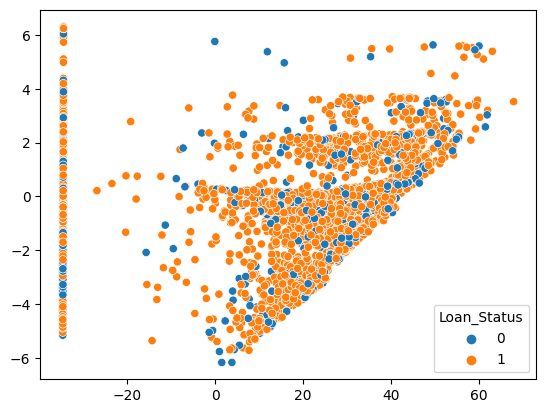

In [83]:
sns.scatterplot(x=pca_value[:,0],y=pca_value[:,1],hue=y_values)

In [84]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(x_train)

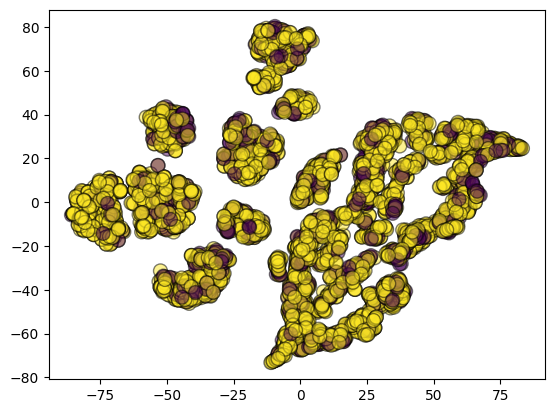

In [85]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_values, cmap='viridis', edgecolors='k', s=100, alpha=0.5)

In [86]:
columns_to_scale=['loan_app*loan_coapp','Loan_Income_Ratio','Coapp_ratio','ApplicantIncome','Loan_Amount_Term','LoanAmount','CoapplicantIncome','Total_Income','calculated_Income','calculated_inc**2']

In [235]:
from sklearn.preprocessing import QuantileTransformer
quantile_transform=QuantileTransformer()

In [236]:
x_train[columns_to_scale] = quantile_transform.fit_transform(x_train[columns_to_scale])
x_train.head(30)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Total_Income,Gender_0,Gender_1,Married_0,Married_1,Dependents_0,...,cluster_lnapp_0,cluster_lnapp_1,cluster_lnapp_2,cluster_lnratio_0,cluster_lnratio_1,cluster_lnratio_2,cluster_coratio_0,cluster_coratio_1,cluster_coratio_2,anomaly_scores
0,0.687187,0.000000,0.000000,0.392893,0.700200,False,True,False,True,True,...,True,False,False,False,True,False,False,True,False,0.065356
2,0.276861,0.528590,0.000000,0.028529,0.700200,True,False,True,False,True,...,False,False,True,False,True,False,True,False,False,-0.035516
4,0.594213,0.000000,0.000000,0.783784,0.250250,False,True,False,True,False,...,True,False,False,False,True,False,False,True,False,0.064454
5,0.072598,0.919826,0.553554,0.905906,0.700200,True,False,False,True,True,...,False,True,False,False,False,True,False,False,True,-0.031292
6,0.450502,0.671905,0.000000,0.995996,0.700200,False,True,False,True,False,...,False,False,True,False,True,False,False,False,True,-0.043894
7,0.169048,0.622542,0.000000,0.465966,0.700200,False,True,False,True,False,...,False,False,True,False,True,False,False,False,True,-0.025168
8,0.887423,0.000000,0.000000,0.008008,0.700200,False,True,False,True,False,...,True,False,False,False,True,False,False,True,False,-0.014602
10,0.368368,0.468661,0.630130,0.678178,0.250250,False,True,False,True,False,...,False,False,True,False,False,True,True,False,False,-0.004453
11,0.897898,0.635627,0.000000,0.783784,0.250250,False,True,False,True,False,...,False,True,False,False,True,False,True,False,False,0.010771
12,0.917158,0.000000,0.000000,0.053053,0.479980,False,True,True,False,True,...,True,False,False,False,True,False,False,True,False,-0.055182


In [89]:
x_train['calculated_inc**2']

0      0.528529
2      0.227663
4      0.472672
5      0.276335
6      0.471460
         ...   
493    0.904346
494    0.256404
496    0.159079
498    0.079777
499    0.704689
Name: calculated_inc**2, Length: 4971, dtype: float32

In [237]:
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_values,test_size=0.4,random_state=42,shuffle=True)

In [91]:
from sklearn.metrics import make_scorer

In [92]:
mcc=make_scorer(matthews_corrcoef)

In [93]:
print(x_train.shape)
print(x_cv.shape)

(2982, 51)
(1989, 51)


In [94]:
class_weight=np.sum(y_values==0)/np.sum(y_values==1)
print(class_weight)

0.2154034229828851


In [238]:
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'tree_method': trial.suggest_categorical('tree_method', ['hist']),
        'device':trial.suggest_categorical('device',['cuda']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1,log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight':trial.suggest_float('scale_pos_weight',1,5),}
    
    model=XGBClassifier(**params)
    sfk=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    score =cross_val_score(model,x_train,y_train,cv=sfk,scoring=mcc)
    score=np.mean(score)
    return score


In [107]:
from xgboost import XGBClassifier

In [239]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-01-12 19:18:21,352] A new study created in memory with name: no-name-7e15a9ca-1088-48f7-9e66-08318648de7c
[I 2025-01-12 19:18:23,972] Trial 0 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'tree_method': 'hist', 'device': 'cuda', 'learning_rate': 0.0015717575335419804, 'n_estimators': 224, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9424877099617172, 'colsample_bytree': 0.9827579232178432, 'scale_pos_weight': 3.2777678670647843}. Best is trial 0 with value: 0.0.
[I 2025-01-12 19:18:28,836] Trial 1 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'tree_method': 'hist', 'device': 'cuda', 'learning_rate': 0.002264965706812388, 'n_estimators': 311, 'max_depth': 12, 'min_child_weight': 10, 'subsample': 0.8764634441411026, 'colsample_bytree': 0.6358038733201691, 'scale_pos_weight': 3.7493893319002063}. Best is trial 0 with value: 0.0.
[I 2025-01-12 19:18:32,317] Trial 2 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'tree_method

In [240]:
best_param=study.best_params
print(best_param)

{'booster': 'dart', 'tree_method': 'hist', 'device': 'cuda', 'learning_rate': 0.009116840753789997, 'n_estimators': 366, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.9713487421537192, 'colsample_bytree': 0.6651297934320167, 'scale_pos_weight': 1.2239098033887175}


In [95]:
xgb_best_param={'booster': 'dart', 'tree_method': 'gpu_hist', 'learning_rate': 0.030571495208972423, 'n_estimators': 223, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.7378387422596433, 'colsample_bytree': 0.6182638905224807}
xgb_best_param2={'booster': 'dart', 'tree_method': 'gpu_hist', 'learning_rate': 0.0028559086869540187, 'n_estimators': 227, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.9990351268169102, 'colsample_bytree': 0.8553293219542076}


In [241]:
xgb_model=XGBClassifier(**best_param)
xgb_model.fit(x_train,y_train)
y_predict=xgb_model.predict(x_cv)
accuracy=accuracy_score(y_cv,y_predict)
print(accuracy)

0.8240321769733534


Text(0, 0.5, 'recall')

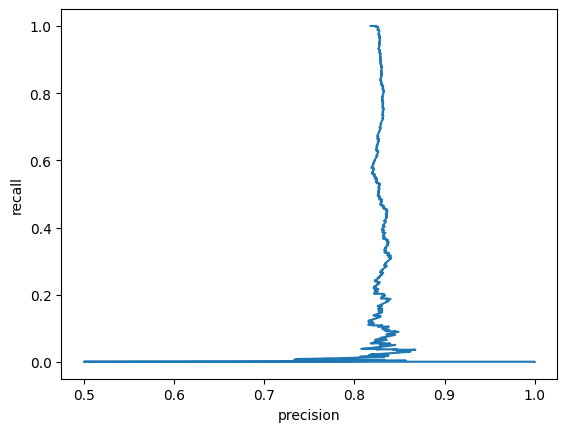

In [242]:
precision,recall,threshold=precision_recall_curve(y_cv,xgb_model.predict_proba(x_cv)[:,1])
plt.plot(precision,recall)
plt.xlabel('precision')
plt.ylabel('recall')

In [243]:
y_cv.value_counts()

Loan_Status
1    1627
0     362
Name: count, dtype: int64

In [244]:
from sklearn.metrics import classification_report


In [245]:
y_passed_zero=np.sum(y_predict[(y_cv==0)]==0)
print(y_passed_zero)

14


In [246]:
y_passed_1=np.sum(y_predict[(y_cv==1)]==1)
print(y_passed_1)

1625


In [247]:
from sklearn.metrics import classification_report
print(classification_report(y_cv,y_predict))

              precision    recall  f1-score   support

           0       0.88      0.04      0.07       362
           1       0.82      1.00      0.90      1627

    accuracy                           0.82      1989
   macro avg       0.85      0.52      0.49      1989
weighted avg       0.83      0.82      0.75      1989



In [248]:
y_probs=xgb_model.predict_proba(x_cv)[:, 1]

In [249]:
from sklearn.metrics import precision_recall_fscore_support

# Define thresholds to evaluate
thresholds = [0.1 * i for i in range(1, 10)]
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)  # Apply threshold
    precision, recall, f1, _ = precision_recall_fscore_support(y_cv, y_pred, average='binary')
    print(f'Threshold: {threshold:.2f} => Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')
    
    # Update best threshold based on F1-score
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Best threshold: {best_threshold:.2f} with F1 score: {best_f1:.2f}')

Threshold: 0.10 => Precision: 0.82, Recall: 1.00, F1: 0.90
Threshold: 0.20 => Precision: 0.82, Recall: 1.00, F1: 0.90
Threshold: 0.30 => Precision: 0.82, Recall: 1.00, F1: 0.90
Threshold: 0.40 => Precision: 0.82, Recall: 1.00, F1: 0.90
Threshold: 0.50 => Precision: 0.82, Recall: 1.00, F1: 0.90
Threshold: 0.60 => Precision: 0.83, Recall: 1.00, F1: 0.90
Threshold: 0.70 => Precision: 0.83, Recall: 0.98, F1: 0.90
Threshold: 0.80 => Precision: 0.83, Recall: 0.85, F1: 0.84
Threshold: 0.90 => Precision: 0.83, Recall: 0.28, F1: 0.42
Best threshold: 0.60 with F1 score: 0.90


In [250]:
auc=average_precision_score(y_cv,xgb_model.predict_proba(x_cv)[:,1])
print(auc)

0.829403112544296


<Axes: xlabel='importance', ylabel='feature'>

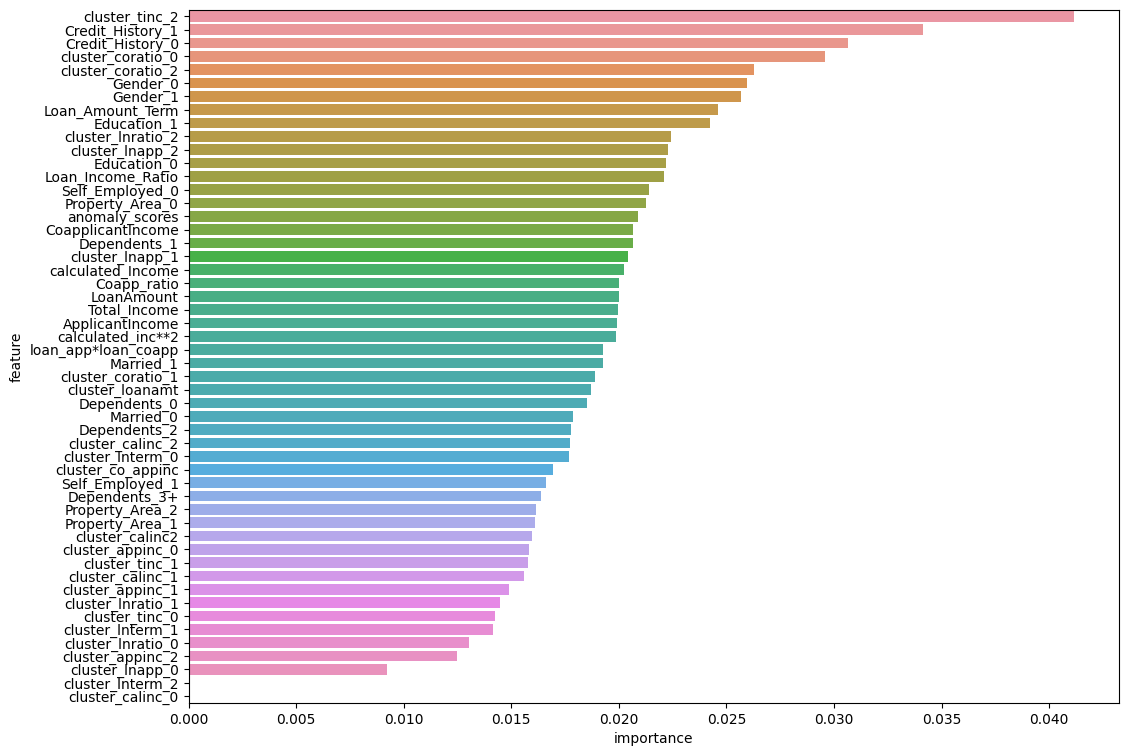

In [251]:
feature_name=xgb_model.feature_names_in_
feature_importance=xgb_model.feature_importances_
x_gbplot=pd.DataFrame({
    'feature':feature_name,
    'importance':feature_importance
})
x_gbplot=x_gbplot.sort_values(by='importance',ascending=False)
plt.figure(figsize=(12,9))
sns.barplot(x=x_gbplot['importance'],y=x_gbplot['feature'],data=x_gbplot)

In [142]:
from sklearn.feature_selection import RFE

In [252]:
test_csv=pd.read_csv(test_path)

In [253]:
id=test_csv.pop('ID')

In [254]:
test_csv.drop(columns=['Loan_ID'],inplace=True)
test_csv

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income
0,1,1,0,1,0,15890,871.075952,188,371,1,1,6000
1,1,1,0,0,1,6582,896.718887,17,373,0,1,6000
2,0,0,0,0,0,7869,572.900354,17,373,1,1,6000
3,1,1,0,0,0,150,0.000000,247,349,1,2,6000
4,1,1,0,0,0,8362,0.000000,17,12,1,2,3750
...,...,...,...,...,...,...,...,...,...,...,...,...
2523,1,1,0,0,0,7276,0.000000,168,367,1,1,3750
2524,1,1,0,0,1,8153,1585.948119,17,406,1,1,3750
2525,1,1,0,0,0,16382,600.813513,17,348,1,2,3750
2526,1,1,0,0,0,7791,0.000000,78,350,0,1,3750


In [255]:
test_csv=pd.get_dummies(test_csv,columns=['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area'])

In [256]:
test_csv['calculated_Income']=test_csv['ApplicantIncome']+test_csv['CoapplicantIncome']

In [257]:
test_csv['calculated_inc**2']=test_csv['calculated_Income']**2

In [258]:
test_csv['ApplicantIncome']=np.log(test_csv['ApplicantIncome']+1)
test_csv['CoapplicantIncome']=np.log(test_csv['CoapplicantIncome']+1)
test_csv['LoanAmount']=np.log(test_csv['LoanAmount']+1)
test_csv['Loan_Amount_Term']=np.log(test_csv['Loan_Amount_Term']+1)
test_csv['Total_Income']=np.log(test_csv['Total_Income']+1)
test_csv['calculated_Income']=np.log(test_csv['calculated_Income']+1)
test_csv['calculated_inc**2']=np.log(test_csv['calculated_inc**2']+1)

In [259]:
test_csv['Total_Income']=test_csv['Total_Income'].astype('float32')

In [260]:
cluster_co_appinc=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='CoapplicantIncome',is_train=False,k_scaled=scale_co_appinc,k_meansd=kmeans_co_appinc)
cluster_loanamt=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='LoanAmount',is_train=False,k_scaled=scale_loanamt,k_meansd=kmeans_loanamt)
cluster_lnterm=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='Loan_Amount_Term',is_train=False,k_scaled=scale_lnterm,k_meansd=kmeans_lnterm)
cluster_tinc=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='Total_Income',is_train=False,k_scaled=scale_tinc,k_meansd=kmeans_tinc)
cluster_calinc=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='calculated_Income',is_train=False,k_scaled=scale_calinc,k_meansd=kmeans_calinc)
cluster_appinc=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='ApplicantIncome',is_train=False,k_scaled=scale_appinc,k_meansd=kmeans_appinc)
cluster_calinc2=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='calculated_inc**2',is_train=False,k_scaled=scale_calinc2,k_meansd=kmeans_calinc2)

In [261]:
test_csv['cluster_co_appinc']=cluster_co_appinc
test_csv['cluster_loanamt']=cluster_loanamt
test_csv['cluster_lnterm']=cluster_lnterm
test_csv['cluster_tinc']=cluster_tinc
test_csv['cluster_calinc']=cluster_calinc
test_csv['cluster_calinc2']=cluster_calinc2
test_csv['cluster_appinc']=cluster_appinc
test_csv

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Total_Income,Gender_0,Gender_1,Married_0,Married_1,Dependents_0,...,Property_Area_2,calculated_Income,calculated_inc**2,cluster_co_appinc,cluster_loanamt,cluster_lnterm,cluster_tinc,cluster_calinc,cluster_calinc2,cluster_appinc
0,9.673508,6.770877,5.241747,5.918894,8.699681,False,True,False,True,True,...,False,9.726874,19.453629,2,2,1,1,0,0,2
1,8.792246,6.799857,2.890372,5.924256,8.699681,False,True,False,True,True,...,False,8.919950,17.839634,2,1,1,1,1,1,0
2,8.970813,6.352456,2.890372,5.924256,8.699681,True,False,True,False,True,...,False,9.041081,18.081925,2,1,1,1,1,1,0
3,5.017280,0.000000,5.513429,5.857933,8.699681,False,True,False,True,True,...,True,5.017280,10.021315,0,2,0,1,2,2,1
4,9.031572,0.000000,2.890372,2.564949,8.229777,False,True,False,True,True,...,True,9.031572,18.062906,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2523,8.892474,0.000000,5.129899,5.908083,8.229777,False,True,False,True,True,...,False,8.892474,17.784673,0,2,1,0,1,1,0
2524,9.006264,7.369568,2.890372,6.008813,8.229777,False,True,False,True,True,...,False,9.183991,18.367777,1,1,2,0,1,1,0
2525,9.703999,6.399948,2.890372,5.855072,8.229777,False,True,False,True,True,...,True,9.740016,19.479914,2,1,0,0,0,0,2
2526,8.960853,0.000000,4.369448,5.860786,8.229777,False,True,False,True,True,...,False,8.960853,17.921449,0,0,0,0,1,1,0


In [262]:
test_csv['loan_app*loan_coapp']=test_csv['ApplicantIncome']*test_csv['CoapplicantIncome']

In [263]:
test_csv['Loan_Income_Ratio']=test_csv['LoanAmount']/test_csv['calculated_Income']
test_csv['Coapp_ratio']=test_csv['CoapplicantIncome']/test_csv['calculated_Income']

In [264]:
cluster_lnapp=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='loan_app*loan_coapp',is_train=False,k_scaled=scale_lnapp,k_meansd=kmeans_lnapp)
cluster_lnratio=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='Loan_Income_Ratio',is_train=False,k_scaled=scale_lnratio,k_meansd=kmeans_lnratio)
cluster_coratio=kmeans_featureGrouping(data=test_csv,n_clusters=3,col='Coapp_ratio',is_train=False,k_scaled=scale_coratio,k_meansd=kmeans_coratio)

In [265]:
test_csv['cluster_lnapp']=cluster_lnapp
test_csv['cluster_lnratio']=cluster_lnratio
test_csv['cluster_coratio']=cluster_coratio

In [266]:
test_csv=pd.get_dummies(test_csv,columns=['cluster_lnterm','cluster_tinc','cluster_calinc','cluster_appinc','cluster_lnapp','cluster_lnratio','cluster_coratio'])

In [267]:
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528 entries, 0 to 2527
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ApplicantIncome      2528 non-null   float64
 1   CoapplicantIncome    2528 non-null   float64
 2   LoanAmount           2528 non-null   float64
 3   Loan_Amount_Term     2528 non-null   float64
 4   Total_Income         2528 non-null   float32
 5   Gender_0             2528 non-null   bool   
 6   Gender_1             2528 non-null   bool   
 7   Married_0            2528 non-null   bool   
 8   Married_1            2528 non-null   bool   
 9   Dependents_0         2528 non-null   bool   
 10  Dependents_1         2528 non-null   bool   
 11  Dependents_2         2528 non-null   bool   
 12  Dependents_3+        2528 non-null   bool   
 13  Education_0          2528 non-null   bool   
 14  Education_1          2528 non-null   bool   
 15  Self_Employed_0      2528 non-null   b

In [268]:
for i in test_csv.columns:
    if test_csv[i].dtype=='float64':
        test_csv[i]=test_csv[i].astype('float32')  

In [269]:
isolation_forest.fit(test_csv) 
test_csv['anomaly_scores'] = isolation_forest.decision_function(test_csv)
test_csv.head(10)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Total_Income,Gender_0,Gender_1,Married_0,Married_1,Dependents_0,...,cluster_lnapp_0,cluster_lnapp_1,cluster_lnapp_2,cluster_lnratio_0,cluster_lnratio_1,cluster_lnratio_2,cluster_coratio_0,cluster_coratio_1,cluster_coratio_2,anomaly_scores
0,9.673509,6.770876,5.241747,5.918894,8.699681,False,True,False,True,True,...,False,True,False,False,False,True,True,False,False,-0.036101
1,8.792246,6.799857,2.890372,5.924256,8.699681,False,True,False,True,True,...,False,False,True,False,True,False,False,False,True,-0.023252
2,8.970814,6.352456,2.890372,5.924256,8.699681,True,False,True,False,True,...,False,False,True,False,True,False,True,False,False,-0.009113
3,5.017280,0.000000,5.513429,5.857933,8.699681,False,True,False,True,True,...,True,False,False,True,False,False,False,True,False,0.018113
4,9.031572,0.000000,2.890372,2.564949,8.229777,False,True,False,True,True,...,True,False,False,False,True,False,False,True,False,0.052998
5,8.284504,7.810522,3.583519,4.779123,8.881975,True,False,False,True,False,...,False,True,False,False,True,False,False,False,True,-0.027069
6,7.069024,0.000000,2.890372,5.908083,8.550048,False,True,True,False,True,...,True,False,False,False,True,False,False,True,False,0.006295
7,8.849227,0.000000,2.890372,5.894403,8.550048,False,True,False,True,True,...,True,False,False,False,True,False,False,True,False,0.064585
8,10.129108,8.259151,2.890372,5.924256,8.229777,False,True,False,True,False,...,False,True,False,False,True,False,False,False,True,-0.036844
9,5.017280,6.854970,2.890372,5.913503,8.699681,False,True,True,False,True,...,False,False,True,False,False,True,False,False,True,-0.024653


In [270]:
columns_to_scale

['loan_app*loan_coapp',
 'Loan_Income_Ratio',
 'Coapp_ratio',
 'ApplicantIncome',
 'Loan_Amount_Term',
 'LoanAmount',
 'CoapplicantIncome',
 'Total_Income',
 'calculated_Income',
 'calculated_inc**2']

In [271]:
test_csv[columns_to_scale] = quantile_transform.transform(test_csv[columns_to_scale])
test_csv.head(10)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Total_Income,Gender_0,Gender_1,Married_0,Married_1,Dependents_0,...,cluster_lnapp_0,cluster_lnapp_1,cluster_lnapp_2,cluster_lnratio_0,cluster_lnratio_1,cluster_lnratio_2,cluster_coratio_0,cluster_coratio_1,cluster_coratio_2,anomaly_scores
0,0.884017,0.668367,0.811311,0.678178,0.700200,False,True,False,True,True,...,False,True,False,False,False,True,True,False,False,-0.036101
1,0.393468,0.669426,0.000000,0.905906,0.700200,False,True,False,True,True,...,False,False,True,False,True,False,False,False,True,-0.023252
2,0.552011,0.597668,0.000000,0.905906,0.700200,True,False,True,False,True,...,False,False,True,False,True,False,True,False,False,-0.009113
3,0.000000,0.000000,0.918418,0.053053,0.700200,False,True,False,True,True,...,True,False,False,True,False,False,False,True,False,0.018113
4,0.708709,0.000000,0.000000,0.000000,0.250250,False,True,False,True,True,...,True,False,False,False,True,False,False,True,False,0.052998
5,0.204448,0.791829,0.471972,0.000000,0.938939,True,False,False,True,False,...,False,True,False,False,True,False,False,False,True,-0.027069
6,0.032322,0.000000,0.000000,0.495495,0.479980,False,True,True,False,True,...,True,False,False,False,True,False,False,True,False,0.006295
7,0.433449,0.000000,0.000000,0.370370,0.479980,False,True,False,True,True,...,True,False,False,False,True,False,False,True,False,0.064585
8,0.953472,0.890804,0.000000,0.905906,0.250250,False,True,False,True,False,...,False,True,False,False,True,False,False,False,True,-0.036844
9,0.000000,0.673682,0.000000,0.569570,0.700200,False,True,True,False,True,...,False,False,True,False,False,True,False,False,True,-0.024653


In [180]:
test_csv.columns = [col.replace('0', '0.0') if 'Credit_History_0' in col else col for col in test_csv.columns]

In [181]:
test_csv.columns = [
    col.replace('Credit_History_0', 'Credit_History_0.0').replace('Credit_History_1', 'Credit_History_1.0')
    if 'Credit_History' in col else col
    for col in test_csv.columns
]

In [182]:
corrected_columns = [
    'Credit_History_0.0' if col == 'Credit_History_0.0.0' else 
    'Credit_History_1.0' if col == 'Credit_History_1' else col
    for col in test_csv.columns
]

In [183]:
test_csv.columns = corrected_columns


In [184]:
x_train.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Total_Income', 'Gender_0', 'Gender_1', 'Married_0',
       'Married_1', 'Dependents_0', 'Dependents_1', 'Dependents_2',
       'Dependents_3+', 'Education_0', 'Education_1', 'Self_Employed_0',
       'Self_Employed_1', 'Credit_History_0', 'Credit_History_1',
       'Property_Area_0', 'Property_Area_1', 'Property_Area_2',
       'calculated_Income', 'calculated_inc**2', 'cluster_co_appinc',
       'cluster_loanamt', 'cluster_calinc2', 'loan_app*loan_coapp',
       'Loan_Income_Ratio', 'Coapp_ratio', 'cluster_lnterm_0',
       'cluster_lnterm_1', 'cluster_lnterm_2', 'cluster_tinc_0',
       'cluster_tinc_1', 'cluster_tinc_2', 'cluster_calinc_0',
       'cluster_calinc_1', 'cluster_calinc_2', 'cluster_appinc_0',
       'cluster_appinc_1', 'cluster_appinc_2', 'cluster_lnapp_0',
       'cluster_lnapp_1', 'cluster_lnapp_2', 'cluster_lnratio_0',
       'cluster_lnratio_1', 'cluster_lnratio_2', 'cluster_co

In [272]:
y_new_test=xgb_model.predict_proba(test_csv)[:,1]

In [273]:
y_test=(y_new_test>=0.6).astype('int')

In [274]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [275]:
test_csv.shape

(2528, 52)

In [276]:
y_test.sum()

2510

In [277]:
subnit_df=pd.DataFrame({
    'ID':id,
    'loan_status':y_test
})

In [278]:
subnit_df.to_csv('my_submission5.csv',index=False)